# Libraries

In [29]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats

from stats import  full_bootstrap_mean_diff, standardize_data, bootstrap_expected_mean_difference
from stats import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import warnings
warnings.filterwarnings("ignore")

# strategies

Перед тем, как сравнивать частоту употребления стратегий в группах, стоит убедиться, что нету для каждой из стратегий зависимости между тем, сколько человек сказал слов


In [4]:
strats_ = pd.read_csv('strategies_fractions.tsv', sep='\t')
strats_.head(4)

,ID,phonetic strategy,derivative strategy,semantic-field strategy,individual association strategy,type
0,pr_A_1,0.227273,0.113636,0.295455,0.363636,senior academics
1,pr_B_1,0.196078,0.058824,0.313725,0.431373,senior academics
2,pr_E_1,0.096154,0.019231,0.192308,0.692308,senior academics
3,pr_G_1,0.254545,0.018182,0.127273,0.600000,senior academics


In [5]:
strats = pd.read_csv('strategies_counts.tsv', sep='\t')
strats.head(4)

,ID,phonetic strategy,derivative strategy,semantic-field strategy,individual association strategy,strat_sum,type
0,pr_A_1,10.0,5.0,13.0,16,44.0,senior academics
1,pr_B_1,10.0,3.0,16.0,22,51.0,senior academics
2,pr_E_1,5.0,1.0,10.0,36,52.0,senior academics
3,pr_G_1,14.0,1.0,7.0,33,55.0,senior academics


<Axes: xlabel='strat_sum', ylabel='phonetic strategy'>

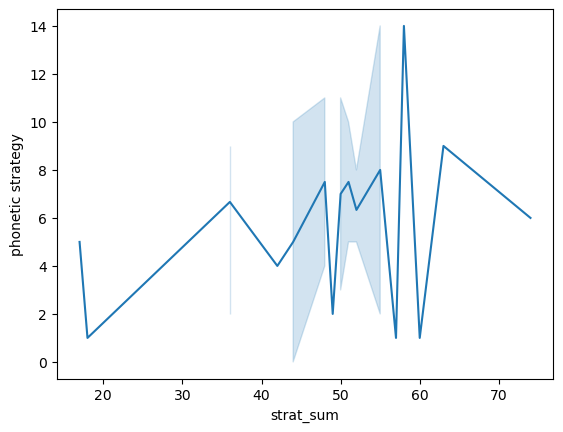

In [6]:
sns.lineplot(strats[strats['type']=='senior academics'], x='strat_sum', y='phonetic strategy')

<Axes: xlabel='phonetic strategy', ylabel='Count'>

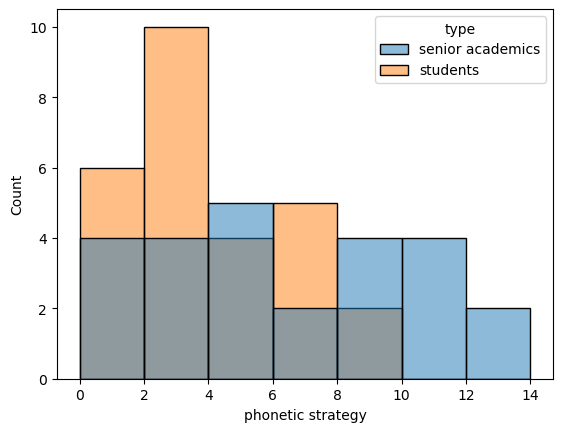

In [7]:
# sns.lineplot(strats[strats['type']=='senior academics'], x='strat_sum', y='fonetics');
sns.histplot(strats, x='phonetic strategy',hue='type')

## количество сказанных слов

In [18]:
res = stats.normaltest(strats[strats['type']!='senior academics']['strat_sum'])
res

NormaltestResult(statistic=7.971465675012011, pvalue=0.01857882407353406)

Наблюдаемая разница средних (стандартизированная): -0.2703303465662201
p-значение: 0.54
Доверительный интервал (95%): [-0.79892369  0.24700149]


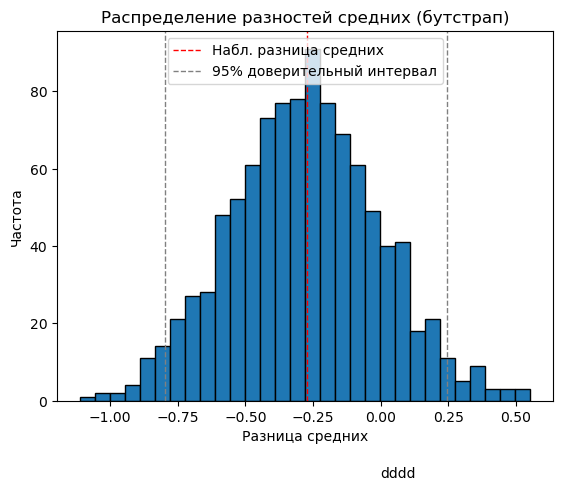

Разница средних при t-тесте (стандартизированная): -0.2703303465662201
p-значение при t-тесте: 0.3350066096207589


In [19]:
# 1. Стандартизация данных
def standardize_data(df, column):
    mean = df[column].mean()
    std = df[column].std()
    df[column + '_standardized'] = (df[column] - mean) / std
    return df

strats = standardize_data(strats, 'strat_sum')


# 2. Бутстрап для сравнения стандартизированных средних
def bootstrap_mean_difference(group1, group2, num_iterations=1000):
    mean_diffs = []
    n1 = len(group1)
    n2 = len(group2)

    for _ in range(num_iterations):
        # Сэмплирование с возвращением
        sample1 = np.random.choice(group1, size=n1, replace=True)
        sample2 = np.random.choice(group2, size=n2, replace=True)
        mean_diff = np.mean(sample1) - np.mean(sample2)
        mean_diffs.append(mean_diff)

    return np.array(mean_diffs)

# Выбираем стандартизированные данные
group1 = strats[strats['type'] != 'senior academics']['strat_sum_standardized'].values
group2 = strats[strats['type'] == 'senior academics']['strat_sum_standardized'].values


mean_diffs_bootstrap = bootstrap_mean_difference(group1, group2)

# Вычисляем p-value и доверительный интервал
observed_diff = np.mean(group1) - np.mean(group2)
p_value = np.mean(np.abs(mean_diffs_bootstrap) >= np.abs(observed_diff))
ci = np.percentile(mean_diffs_bootstrap, [2.5, 97.5])


# Вывод результатов
print("Наблюдаемая разница средних (стандартизированная):", observed_diff)
print("p-значение:", p_value)
print("Доверительный интервал (95%):", ci)

# Строим гистограмму распределения разностей средних
plt.hist(mean_diffs_bootstrap, bins=30, edgecolor='black')
plt.axvline(observed_diff, color='red', linestyle='dashed', linewidth=1, label=f'Набл. разница средних')
plt.axvline(ci[0], color='grey', linestyle='dashed', linewidth=1, label=f'95% доверительный интервал')
plt.axvline(ci[1], color='grey', linestyle='dashed', linewidth=1)
plt.title('Распределение разностей средних (бутстрап)')
plt.xlabel('Разница средних')
plt.ylabel('Частота')
plt.text(0, -20, 'dddd', fontsize=10)
plt.legend()
plt.show()


# Сравнение с t-тестом (для сравнения) - выводим только p-value и разницу средних
t_stat, p_value_ttest = stats.ttest_ind(group1, group2)
print("Разница средних при t-тесте (стандартизированная):", np.mean(group1) - np.mean(group2))
print("p-значение при t-тесте:", p_value_ttest)


между группами академиков и студентов принята гипотеза об отсутствии разницы между средними количества сказанных слов

In [20]:
stats.ttest_ind(strats[strats['type']!='senior academics']['strat_sum'], strats[strats['type']=='senior academics']['strat_sum'])

TtestResult(statistic=-0.9734686470663446, pvalue=0.33500660962075846, df=50.0)

## доказать независимость частот с определенной стратегией от количества сказанных слов

### доказать независимость частот со стратегией "фонетика" от количества сказанных слов

In [21]:
x=strats['phonetic strategy']/strats['strat_sum']
y=strats['strat_sum']
def statistic(x): # permute only `x`
    return stats.pearsonr(x, y).statistic
res_exact = stats.permutation_test((x,), statistic,
    permutation_type='pairings')
res_asymptotic = stats.pearsonr(x, y)
print(res_exact.pvalue, res_asymptotic.pvalue) # asymptotic pvalue is too low
print(res_exact)

0.9068 0.9065481618184839
PermutationTestResult(statistic=-0.016684009954635075, pvalue=0.9068, null_distribution=array([ 0.08618607,  0.14868647, -0.28425339, ..., -0.09562836,
       -0.0273431 , -0.02662816]))


In [23]:
x=strats['phonetic strategy']/strats['strat_sum']
y=strats['strat_sum']
def statistic(x): # permute only `x`
    return stats.spearmanr(x, y).statistic
res_exact = stats.permutation_test((x,), statistic,
    permutation_type='pairings')
res_asymptotic = stats.spearmanr(x, y)
res_exact.pvalue, res_asymptotic.pvalue # asymptotic pvalue is too low

(0.3258, 0.32922028386214164)

In [24]:
res_exact

PermutationTestResult(statistic=0.1380092381063527, pvalue=0.3258, null_distribution=array([ 0.26246132, -0.15575756,  0.07843475, ..., -0.14335512,
       -0.11996155,  0.05726507]))

In [25]:
x=strats['phonetic strategy']/strats['strat_sum']
y=strats['strat_sum']
def statistic(x): # permute only `x`
    return stats.kendalltau(x, y).statistic
res_exact = stats.permutation_test((x,), statistic,
    permutation_type='pairings')
res_asymptotic = stats.kendalltau(x, y)
res_exact.pvalue, res_asymptotic.pvalue # asymptotic pvalue is too low

(0.3804, 0.37141203727581673)

In [26]:
res_exact

PermutationTestResult(statistic=0.08712786184136909, pvalue=0.3804, null_distribution=array([ 0.        ,  0.09406725,  0.06708074, ..., -0.11719854,
       -0.09021203, -0.07479117]))

не отвергаем нулевую гипотезу, частота сказанных слов со стратегией фонетика не коррелирует со общим количеством сказанных слов

Более того, в этой связи есть линейность?

(0.0, 15.0)

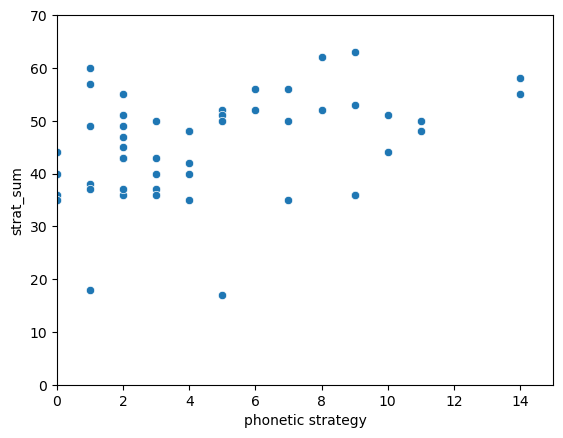

In [28]:
sns.scatterplot(strats, y='strat_sum', x='phonetic strategy');
plt.ylim(0,70)
plt.xlim(0,15)

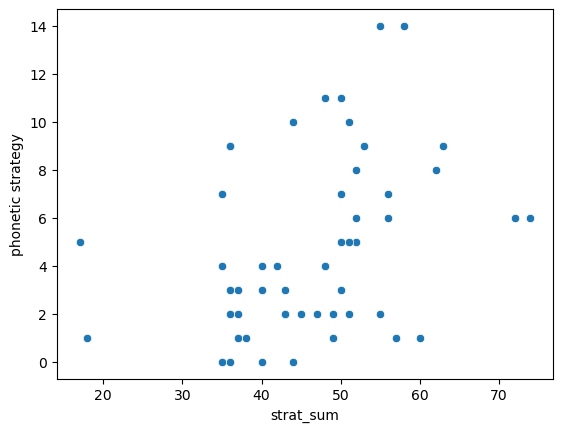

In [29]:
sns.scatterplot(strats, y='phonetic strategy', x='strat_sum');
# plt.ylim(0,70)
# plt.xlim(0,15)

поэтому не стоит сравнивать количества сказанных слов со стратегией фонетика напрямую, их надо нормализовывать по количеству сказанных слов

или стоит?? стоит, потому что на графике не видно связи, точки разбросаны

### доказать независимость частот со стратегией "лексика" от количества сказанных слов

In [30]:
strats.columns

Index(['ID', 'phonetic strategy', 'derivative strategy',
       'semantic-field strategy', 'individual association strategy',
       'strat_sum', 'type', 'strat_sum_standardized'],
      dtype='object')

## сравнение количества слов по стратегиям между группами

In [7]:
strats.head(1)

,ID,phonetic strategy,derivative strategy,semantic-field strategy,individual association strategy,strat_sum,type
0,pr_A_1,10.0,5.0,13.0,16,44.0,senior academics


In [8]:
strats.columns

Index(['ID', 'phonetic strategy', 'derivative strategy',
       'semantic-field strategy', 'individual association strategy',
       'strat_sum', 'type'],
      dtype='object')

In [18]:
# full_bootstrap_mean_diff(strats, 'strat_sum')
full_bootstrap_analysis(strats, 'strat_sum')

Статистика Хи-квадрат: 3.001383187847609e-27
P-значение: 1.0
Observed difference (standardized): -0.2703303465662201
CI for observed difference [-2.2706282677023193, 1.729967574569879]
Cohen's d (effect size): -0.26488428232173367
Expected mean diffs are normal disrtibuted
Нормальность средних разниц: p=0.0778
Хи квадрат дисперсии разниц: p=1.0000
P-значение для разницы средних: 0.3208
П-значение для разницы дисперсий: 0.2009
Доверительный интервал для средней разницы H0: (-0.5275, 0.5361)
Эффект (Cohen's D): -0.2649


/home/aryuna/work/sharapkova/pos_febr/stats.py:179: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 10000.
  


(array([-0.12419485, -0.19286093,  0.0601336 , ...,  0.41199645,
         0.38071072, -0.38599273]),
 array([-0.81439469,  0.04844227, -0.40191832, ..., -0.12872898,
        -0.34971612,  0.10982604]),
 array([-0.43638718, -0.70972856,  0.24039601, ...,  1.34587189,
         1.31576583, -1.22849393]),
 0.3208,
 0.2009,
 (-0.5275267826323103, 0.536066025293132),
 -0.26488428232173367)

принимаем нулевую гипотезу об отсутствии различий в среднем количестве сказанных слов

In [10]:
strategies_list = ['phonetic strategy', 'derivative strategy',
       'semantic-field strategy', 'individual association strategy']

In [19]:
pval = []
es = []
for i in strategies_list:
    print (i)
    mean_diffs, var_diffs, t_stats, p_value_mean, p_value_var, ci_mean, cohens_d = full_bootstrap_analysis(strats, i)
    # ci, p_value, observed_diff, mdelta, cohens_d = full_bootstrap_mean_diff(strats, i)
    pval.append(p_value_mean)
    es.append(cohens_d)
    print('______________')
    

phonetic strategy
Статистика Хи-квадрат: 4.281675291002209e-27
P-значение: 1.0
Observed difference (standardized): -0.7115128827610983
CI for observed difference [-2.5963391040420842, 1.173313338519888]
Cohen's d (effect size): -0.7398906246454715
Expected mean diffs are normal disrtibuted
Нормальность средних разниц: p=0.8868
Хи квадрат дисперсии разниц: p=1.0000
P-значение для разницы средних: 0.0095
П-значение для разницы дисперсий: 0.0285
Доверительный интервал для средней разницы H0: (-0.5411, 0.5468)
Эффект (Cohen's D): -0.7399
______________
derivative strategy
Статистика Хи-квадрат: 3.6480339107988e-27
P-значение: 1.0
Observed difference (standardized): -0.0318556238103649
CI for observed difference [-2.0514592138775405, 1.9877479662568107]
Cohen's d (effect size): -0.030915484095687527
Expected mean diffs are not normal disrtibuted
Нормальность средних разниц: p=0.0000
Хи квадрат дисперсии разниц: p=1.0000
P-значение для разницы средних: 0.9110
П-значение для разницы дисперсий

In [20]:
strategies_list
#ofld

['phonetic strategy',
 'derivative strategy',
 'semantic-field strategy',
 'individual association strategy']

In [21]:
pval

[0.0095, 0.911, 0.0022, 0.0843]

In [22]:
es

[-0.7398906246454715,
 -0.030915484095687527,
 -0.9162600429636434,
 0.47685591304288694]

In [40]:
# plt.text(2.7, 257.5, f"ES = {es[3]:.1f}", rotation = 0, fontsize = 11
#          )       

# plt.text(2.7, 240, f"p value = {pval[3]:.3f}", rotation = 0, fontsize = 11 
#          )      

In [41]:
int(3/2)

1

In [14]:
# sns.set_theme(style="ticks", palette="pastel");
# fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10, 12), dpi=300)
# j=0
# for i in strategies_list:
    

#     ax = sns.boxplot(strats, y=i, x='type', hue='type', palette={'senior academics':'r', 'students':'g'}
#                      ,ax=axs[j%2][int(j/2)]
#                      );
    
#     ax.set_xlabel(f'Strategy "{i}"')

#     ax.text(0.02, 1.1, f"ES ({i}) = {es[j]:.2f}", ha="left", va="top", transform=ax.transAxes)
#     ax.text(0.02, 1.05, f"p value = {pval[j]:.3f}", ha="left", va="top", transform=ax.transAxes)

#     # ax.text(0, 10.2*y_lim, f"ES = {es[j]:.2f}" )
#     # ax.text(0, 10.15*y_lim, f"p value = {pval[j]:.3f}" )
#     j+=1


# # plt.xlabel('group')
# # plt.title(f'Strategies between groups')
# fig.suptitle("Strategy Use by Group: Senior Academics vs. Students", fontsize="x-large")
# plt.tight_layout()
# plt.show();

## сравнение фракций для каждой стратегии между группами

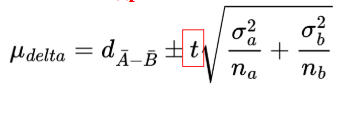

In [8]:
strategies_list = ['phonetic strategy',
 'derivative strategy',
 'semantic-field strategy',
 'individual association strategy']
strategies_list

['phonetic strategy',
 'derivative strategy',
 'semantic-field strategy',
 'individual association strategy']

In [9]:
strategies_dict = {'phonetic strategy': 'S1',
 'derivative strategy': 'S2',
 'semantic-field strategy' : 'S3',
 'individual association strategy' : 'S4'}

# S1. Phonetic strategy

# S2. Derivative strategy

# S3. Semantic-field strategy

# S4. Individual association strategy

In [47]:
paper_table = pd.DataFrame(columns=['Variable', 'Normal sampling distribution', 'H0 CI', 'Delta observed' ,'Cohens delta', 'Bootstrap p value', 'Stat metric value', 'Stat p value'])
paper_table

,Variable,Normal sampling distribution,H0 CI,Delta observed,Cohens delta,Bootstrap p value,Stat metric value,Stat p value


phonetic strategy
Статистика Хи-квадрат: 1.0545483411338047e-27
P-значение: 1.0
Observed difference (standardized): -0.7432813601897033
CI for observed difference [-2.615443947539535, 1.1288812271601285]
Cohen's d (effect size): -0.7781543525202361
Expected mean diffs are normal distributed
T-student p_value: 0.0070
Нормальность средних разниц: p=0.5499
Хи квадрат дисперсии разниц: p=1.0000
P-значение для разницы средних: 0.0070
П-значение для разницы дисперсий: 0.0089
Доверительный интервал для средней разницы H0: (-0.5427, 0.5395)
Эффект (Cohen's D): -0.7782


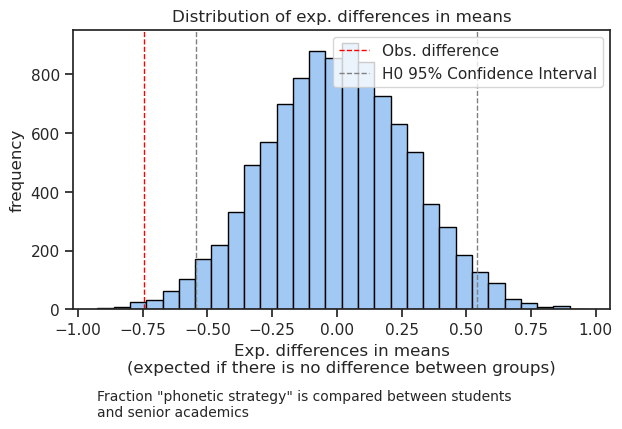

______________
derivative strategy
Статистика Хи-квадрат: 2.924805480799445e-27
P-значение: 1.0
Observed difference (standardized): 0.17080970708216622
CI for observed difference [-1.8412039681177672, 2.1828233822820997]
Cohen's d (effect size): 0.16639401113800983
Expected mean diffs are normal distributed
T-student p_value: 0.5708
Нормальность средних разниц: p=0.3163
Хи квадрат дисперсии разниц: p=1.0000
P-значение для разницы средних: 0.5325
П-значение для разницы дисперсий: 0.1289
Доверительный интервал для средней разницы H0: (-0.5523, 0.5368)
Эффект (Cohen's D): 0.1664


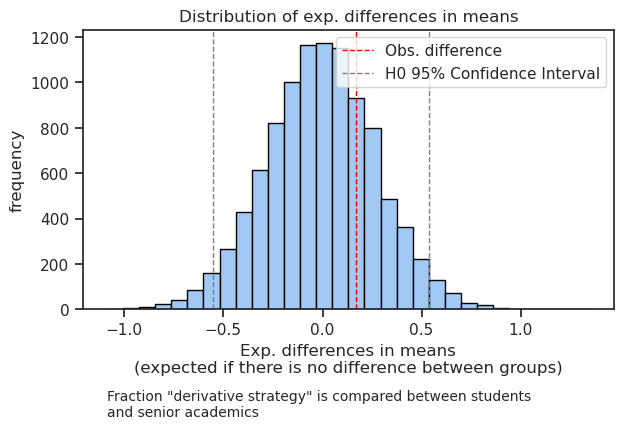

______________
semantic-field strategy
Статистика Хи-квадрат: 2.0635222755234517e-27
P-значение: 1.0
Observed difference (standardized): -0.8378024566518034
CI for observed difference [-2.668340853269849, 0.9927359399662425]
Cohen's d (effect size): -0.8970545595062808
Expected mean diffs are normal distributed
T-student p_value: 0.0020
Нормальность средних разниц: p=0.2306
Хи квадрат дисперсии разниц: p=1.0000
P-значение для разницы средних: 0.0027
П-значение для разницы дисперсий: 0.0060
Доверительный интервал для средней разницы H0: (-0.5430, 0.5368)
Эффект (Cohen's D): -0.8971


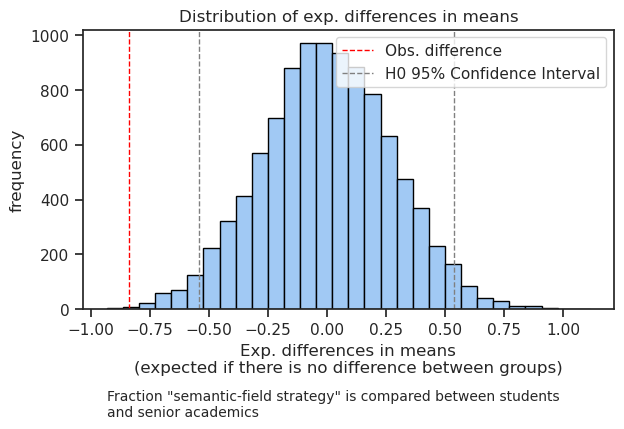

______________
individual association strategy
Статистика Хи-квадрат: 4.374258320261344e-27
P-значение: 1.0
Observed difference (standardized): 0.8987988967047231
CI for observed difference [-0.901051033363746, 2.6986488267731925]
Cohen's d (effect size): 0.9787737344714298
Expected mean diffs are normal distributed
T-student p_value: 0.0014
Нормальность средних разниц: p=0.7499
Хи квадрат дисперсии разниц: p=1.0000
P-значение для разницы средних: 0.0012
П-значение для разницы дисперсий: 0.0531
Доверительный интервал для средней разницы H0: (-0.5269, 0.5462)
Эффект (Cohen's D): 0.9788


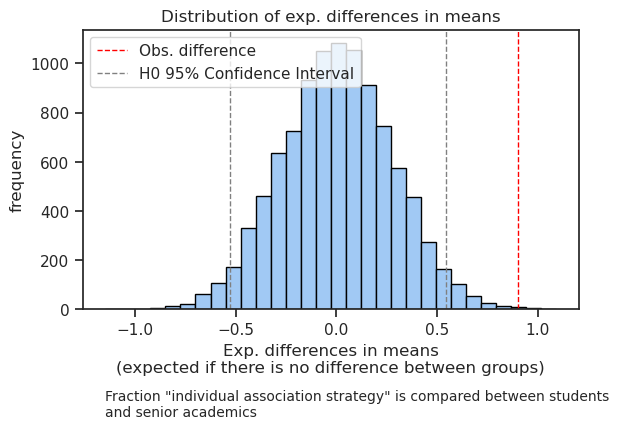

______________


In [79]:
pval = []
# es = []
pval_st = []
normality = []
for i in strategies_list:
    print (i)
    # mean_diffs, var_diffs, t_stats, p_value_mean, p_value_var, ci_mean, cohens_d, pst = full_bootstrap_analysis(strats_, i)
    # p_value_mean, normal, pst = full_bootstrap_analysis(strats_, i)
    # ci, p_value, observed_diff, mdelta, cohens_d = full_bootstrap_mean_diff(strats, i)
    mean_expected_diffs, normal, ci_mean, delta ,cohens_d, p_value_mean, Crit_metric, pst = full_bootstrap_analysis(strats_, i)
    pval.append(p_value_mean)
    # es.append(cohens_d)
    pval_st.append(pst)
    normality.append(normal)
    plot_bresults(mean_expected_diffs, delta, ci_mean, i, text_add="Fraction ")
    paper_table.loc[len(paper_table)] = [f'Fraction of {i}', normal, [round(x, 2) for x in ci_mean]
                                         , round(delta, 2), round(cohens_d, 2)
                                         , round(p_value_mean, 4), round(Crit_metric, 2), round(pst, 4)]
    print('______________')

In [49]:
paper_table

,Variable,Normal sampling distribution,H0 CI,Delta observed,Cohens delta,Bootstrap p value,Stat metric value,Stat p value
0,Fraction of phonetic strategy,False,"[-0.55, 0.53]",-0.74,-0.78,0.0075,219.50,0.0313
1,Fraction of derivative strategy,True,"[-0.54, 0.55]",0.17,0.17,0.5266,0.60,0.5649
2,Fraction of semantic-field strategy,True,"[-0.54, 0.53]",-0.84,-0.90,0.0022,-3.21,0.0019
3,Fraction of individual association strategy,True,"[-0.53, 0.54]",0.90,0.98,0.0010,3.54,0.0015


In [92]:
# pval = []
# es = []
# for i in strategies_list:
#     ci, p_value, observed_diff, mdelta, cohens_d = full_bootstrap_mean_diff(strats_, i,num_it=10000)
#     pval.append(p_value)
#     es.append(cohens_d)

In [50]:
strategies_dict

{'phonetic strategy': 'S1',
 'derivative strategy': 'S2',
 'semantic-field strategy': 'S3',
 'individual association strategy': 'S4'}

In [51]:
strats_.head()

,ID,phonetic strategy,derivative strategy,semantic-field strategy,individual association strategy,type,phonetic strategy_standardized,derivative strategy_standardized,semantic-field strategy_standardized,individual association strategy_standardized
0,pr_A_1,0.227273,0.113636,0.295455,0.363636,senior academics,1.599909,0.535599,1.116055,-2.028730
1,pr_B_1,0.196078,0.058824,0.313725,0.431373,senior academics,1.200585,-0.141556,1.322812,-1.513977
2,pr_E_1,0.096154,0.019231,0.192308,0.692308,senior academics,-0.078569,-0.630684,-0.051176,0.468966
3,pr_G_1,0.254545,0.018182,0.127273,0.600000,senior academics,1.949033,-0.643642,-0.787124,-0.232515
4,pr_I_1,0.083333,0.020833,0.187500,0.708333,senior academics,-0.242687,-0.610886,-0.105581,0.590751


In [52]:
strats_.columns

Index(['ID', 'phonetic strategy', 'derivative strategy',
       'semantic-field strategy', 'individual association strategy', 'type',
       'phonetic strategy_standardized', 'derivative strategy_standardized',
       'semantic-field strategy_standardized',
       'individual association strategy_standardized'],
      dtype='object')

In [53]:
boxpl_strats = strats_[['type', 'ID',
       'phonetic strategy', 'derivative strategy',
       'semantic-field strategy',
       'individual association strategy']].melt(id_vars=['type', 'ID'], value_vars=['phonetic strategy', 'derivative strategy',
       'semantic-field strategy',
       'individual association strategy'])

In [54]:
boxpl_strats['Strategy'] = boxpl_strats['variable'].apply(lambda x: strategies_dict.get(x
                                                                                        )
                                                            )
boxpl_strats['value'] = boxpl_strats['value']*100

In [55]:
boxpl_strats.head(2)

,type,ID,variable,value,Strategy
0,senior academics,pr_A_1,phonetic strategy,22.727273,S1
1,senior academics,pr_B_1,phonetic strategy,19.607843,S1


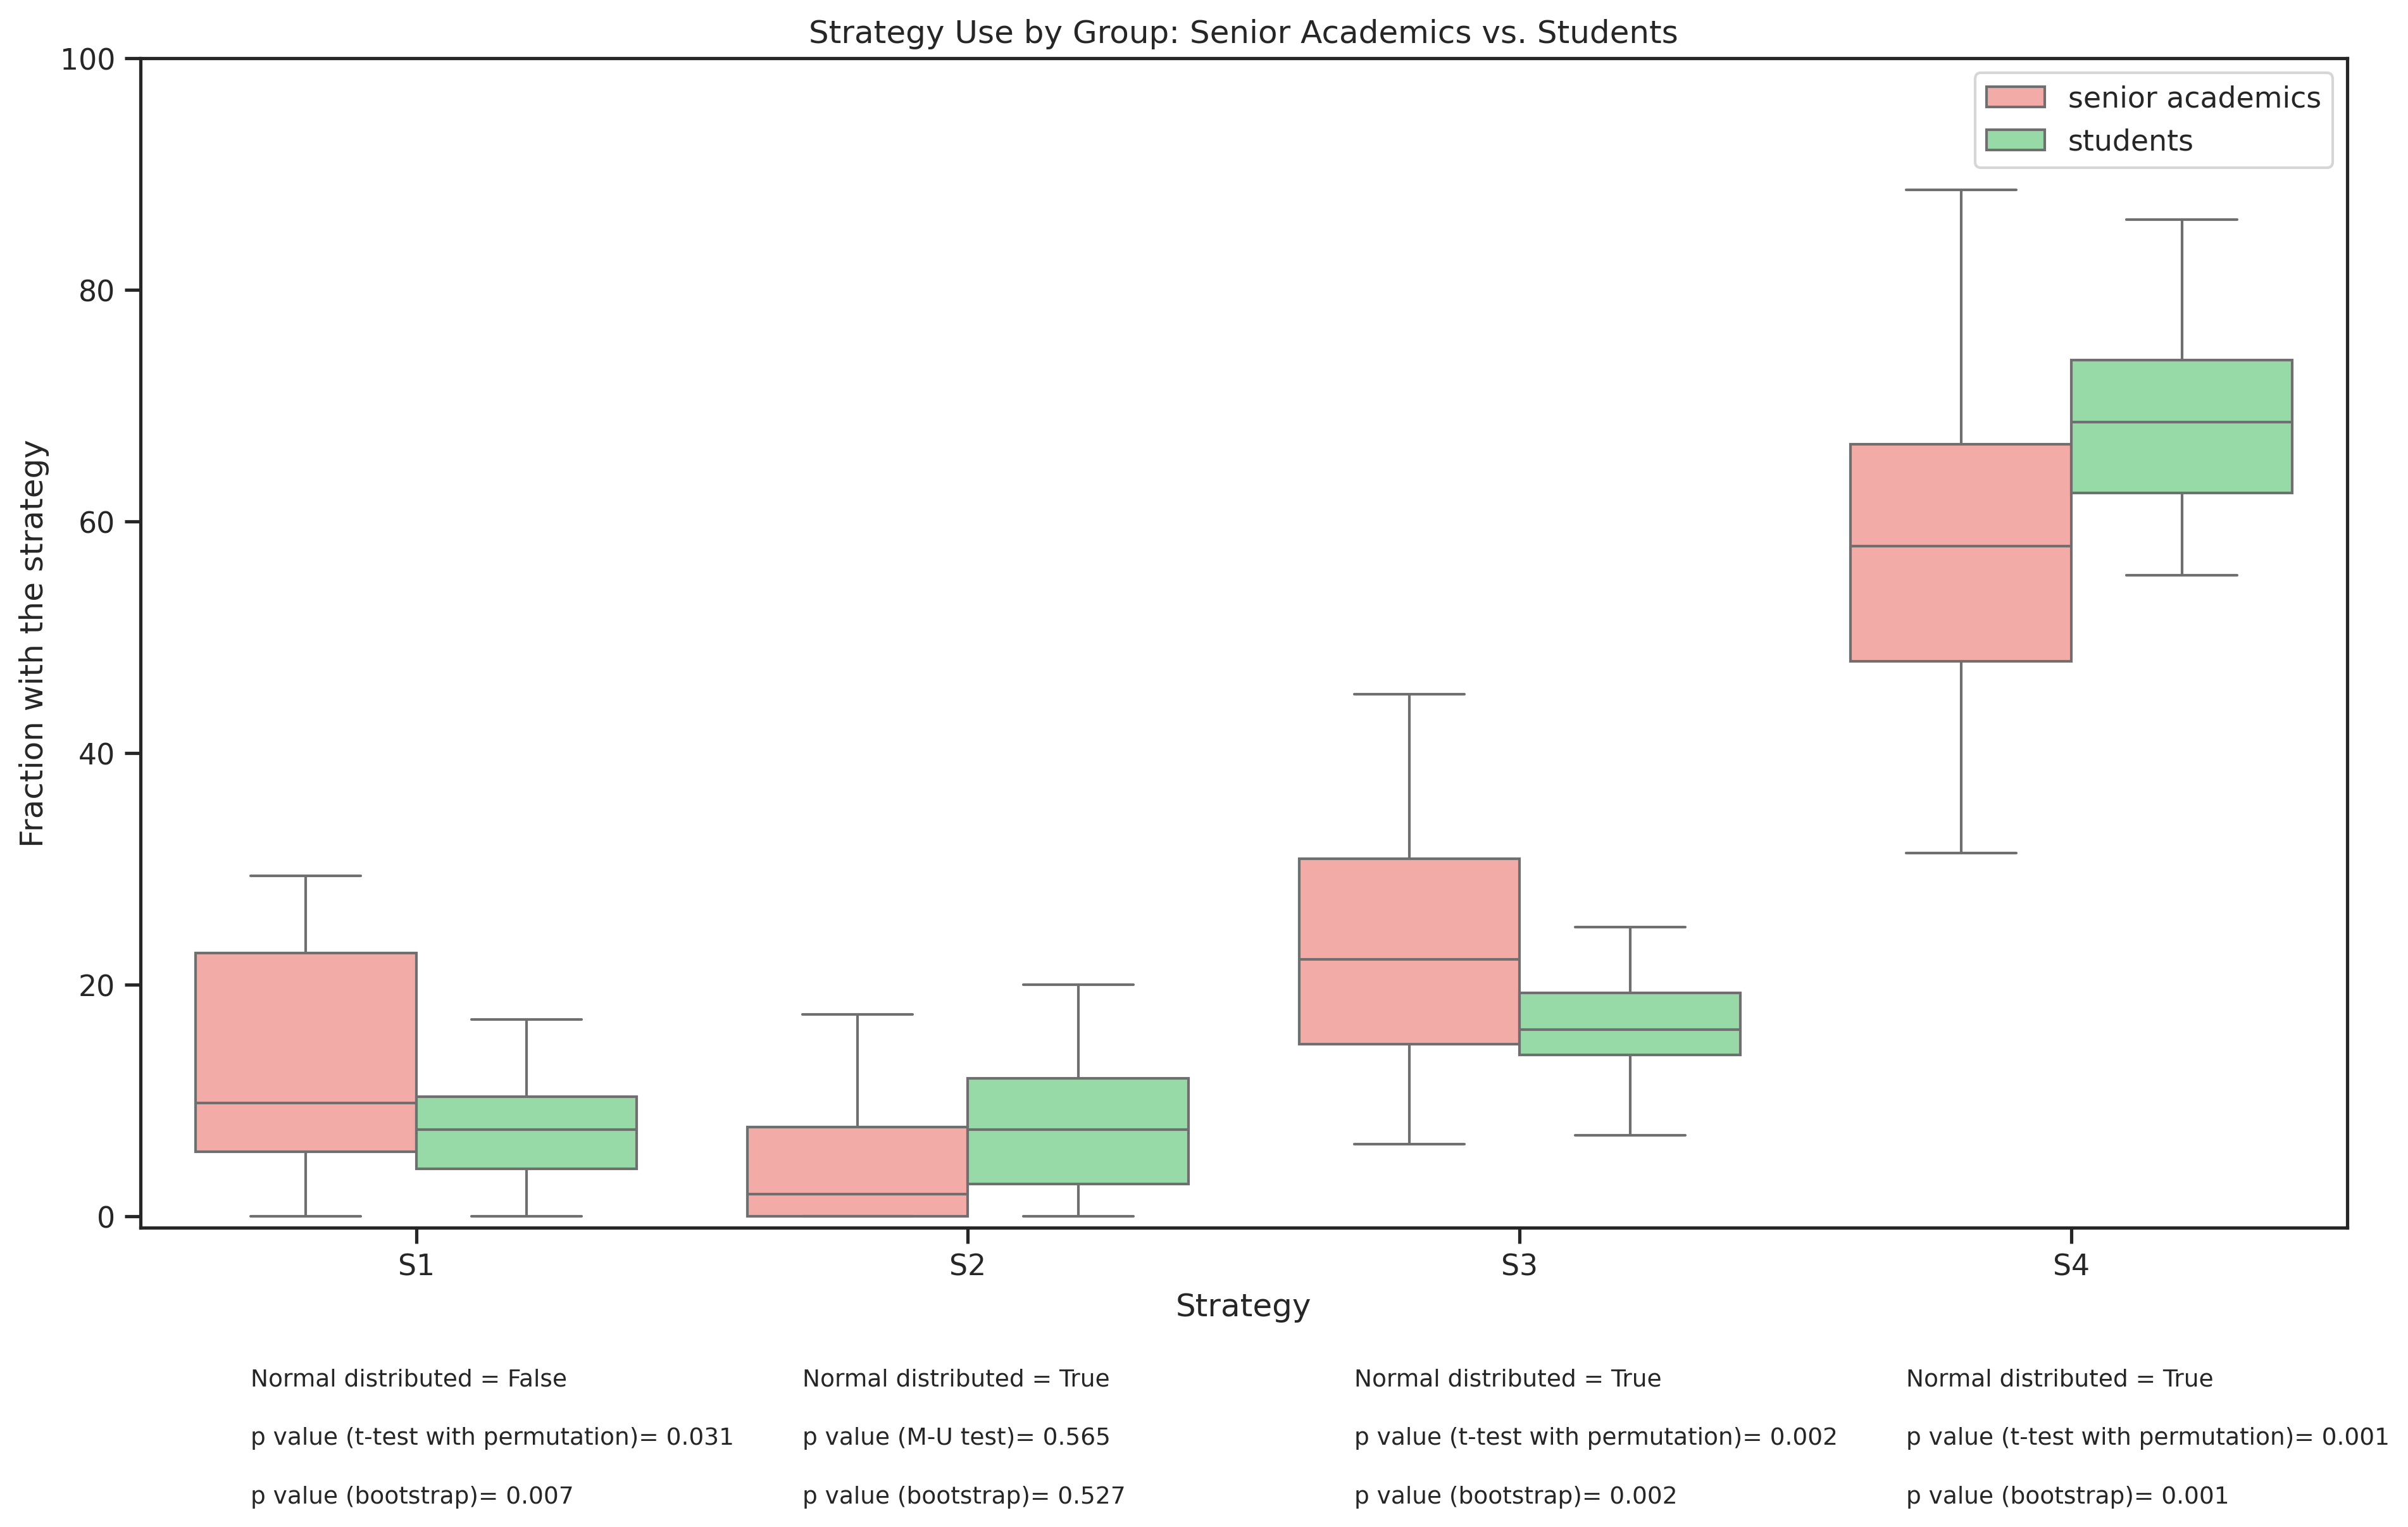

In [59]:
sns.set_theme(style="ticks", palette="pastel");
fig, axs = plt.subplots(figsize=(15, 8), dpi=300)
# plt.figure(figsize=(10, 6))
g = sns.boxplot(data = boxpl_strats.sort_values(['Strategy']), x='Strategy',y='value', hue='type', palette={'senior academics':'r', 'students':'g'}, showfliers = False);
plt.xlabel('Strategy')
plt.ylabel('Fraction with the strategy')
plt.title(f'Strategy Use by Group: Senior Academics vs. Students')
plt.ylim(-1, 100)

# ax.text(0.02, 1.05, f"p value = {pval[j]:.3f}", ha="left", va="top", transform=ax.transAxes)
for i in range(len(normality)):
      g.text(i*0.25+0.05, -0.12, f"Normal distributed = {str(normality[i])}", rotation = 0, fontsize = 9, ha="left", va="top", transform=g.transAxes )         # Size
      if pval_st[i]<=0.05:
            g.text(i*0.25+0.05, -0.17, f"p value (t-test with permutation)= {pval_st[i]:.3f}", rotation = 0, fontsize = 9, ha="left", va="top", transform=g.transAxes )
      else:
            g.text(i*0.25+0.05, -0.17, f"p value (M-U test)= {pval_st[i]:.3f}", rotation = 0, fontsize = 9, ha="left", va="top", transform=g.transAxes )
      g.text(i*0.25+0.05, -0.22, f"p value (bootstrap)= {pval[i]:.3f}", fontsize = 9 , ha="left", va="top", transform=g.transAxes)
    
g.legend( bbox_to_anchor=(1, 1))
fig.savefig(f'figures/Strategy Use by Group: Senior Academics vs. Students.png', bbox_inches='tight')

In [116]:
# sns.set_theme(style="ticks", palette="pastel");
# fig, axs = plt.subplots(ncols=4, nrows=1, figsize=(15, 8), dpi=300)
# j=0
# for i in strategies_list:
    

#     ax = sns.boxplot(strats_, y=strats_[i]*100, x='type', hue='type', palette={'senior academics':'r', 'students':'g'}
#                      ,ax=axs[j]
#                      );
    
#     # ax.set_xlabel(f'Strategy "{i}"',    loc='left')
#     ax.set_title(f'Strategy "{strategies_dict.get(i)}"')
#     ax.set_xlabel('group')

#     # T, pst = stats.ttest_ind(a, b, equal_var=False, permutations=10000)
#     # ax.text(0.02, 1.1, f"ES ({i}) = {es[j]:.2f}", ha="left", va="top", transform=ax.transAxes)
#     # ax.text(0.02, 1.05, f"p value = {pval[j]:.3f}", ha="left", va="top", transform=ax.transAxes)
#     # ax.text(0.02, -0.2, f"T ({i}) = {T:.2f}", ha="left", va="top", transform=ax.transAxes)
#     ax.text(0.02, -0.15, f"p value (t_test with permutation)= {pval_st[j]:.3f}", ha="left", va="top", transform=ax.transAxes
#             , fontsize =9)
#     ax.text(0.02, -0.20, f"Normal distributed = {str(normality[j])}", ha="left", va="top", transform=ax.transAxes
#             , fontsize =9)
#     ax.text(0.02, -0.1, f"p value (bootstrap)= {pval[j]:.3f}", ha="left", va="top", transform=ax.transAxes)
#     ax.set_ylim(-1,100)
    
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
#     # ax.spines['bottom'].set_visible(False)
#     if j!=0:
#         ax.set(ylabel=None)
#         ax.tick_params(left=False)
#         ax.set(yticklabels=[])
#         ax.spines['left'].set_visible(False)
#     else:
#         ax.set(ylabel= "Fraction with the strategy")
        
#     # ax.text(0, 10.2*y_lim, f"ES = {es[j]:.2f}" )
#     # ax.text(0, 10.15*y_lim, f"p value = {pval[j]:.3f}" )
#     j+=1


# # plt.xlabel('group')
# # plt.title(f'Strategies between groups')
# fig.suptitle("Strategy Use by Group: Senior Academics vs. Students", fontsize="x-large")
# fig.text(0.06, -0.04, "Fraction = (words count with Si strategy)/(words count) * 100")
# plt.tight_layout()
# plt.show();

# Words

In [60]:
words = pd.read_csv('words.tsv', sep='\t')

df = words.fillna('0')
# df['Стратегия'] = df['Стратегия'].str[0]
# def renamestrats(row):
#     '''
#     df['phonetic strategy'] = df['1'] 
#     df['derivation'] = df['2']
#     df['lexico-semantic field'] = df['3'] + df['4'] + df['5'] + df['6'] + df['7']
#     df['other'] = df['8']

#     '''
    
    
#     stratsfict = {'1':'fonetics', '2': 'derivation', 
#                   '8':'other', **dict.fromkeys(['n', '0'], 'None')
#                   }
#     stratsfict.update(dict.fromkeys(['3', '4', '5', '6', '7'], 'lexico-semantic field'))
#     #print(stratsfict[row['Стратегия']])
#     row['strategy_name']=stratsfict[row['Стратегия']]
#     return row

# df = df.apply(renamestrats, axis=1)
df['frequency'] = df['frequency'].astype('float', errors = 'ignore')
df['pause'] = df['pause'].astype('float', errors='ignore' )
df.head()

,Unnamed: 0,ID,quota sec,word,previous + word,first_letter,strategy,order_letter,order_whole_test,frequency,...,VP,VS,N of words,N of words_P,N of words_O,N of words_S,mean pause,type,strategy_name,strategy_paper_name
0,0,Б_В_10,1,пара,0,п,0,1.0,1,152.7,...,0,0,59,28,13,18,2.390357,students,0,0
1,1,Б_В_10,1,период,"['пара', 'период']",п,8,2.0,2,204.2,...,0,0,59,28,13,18,2.390357,students,individual association strategy,S4
2,2,Б_В_10,1,парад,"['период', 'парад']",п,11,3.0,3,13.2,...,1.0,0,59,28,13,18,2.390357,students,phonetic strategy,S1
3,3,Б_В_10,1,предлог,"['парад', 'предлог']",п,8,4.0,4,12.7,...,1.0,0,59,28,13,18,2.390357,students,individual association strategy,S4
4,4,Б_В_10,1,по,"['предлог', 'по']",п,3,5.0,5,5786.7,...,0,0,59,28,13,18,2.390357,students,semantic-field strategy,S3


In [61]:
words.columns

Index(['Unnamed: 0', 'ID', 'quota sec', 'word', 'previous + word',
       'first_letter', 'strategy', 'order_letter', 'order_whole_test',
       'frequency', 'pause', 'VP', 'VS', 'N of words', 'N of words_P',
       'N of words_O', 'N of words_S', 'mean pause', 'type', 'strategy_name',
       'strategy_paper_name'],
      dtype='object')

In [62]:
df[df['strategy_name']=='individual association strategy'][['type','frequency']]

,type,frequency
1,students,204.2
3,students,12.7
5,students,18.5
6,students,16.3
8,students,2.1
...,...,...
2562,senior academics,0.0
2563,senior academics,3.3
2564,senior academics,2.0
2565,senior academics,5.5


In [20]:
# df['frequency'] = pd.to_numeric(df['frequency'].str.replace(',','.'))

In [63]:
cols = df.select_dtypes('number').columns  # limits to a (float), b (int) and e (timedelta)
df_sub = df.loc[:, 'frequency']


# OPTION 1: z-score filter: z-score < 3
#lim = np.abs((df_sub - df_sub.mean()) / df_sub.std(ddof=0)) < 3

# OPTION 2: quantile filter: discard 1% upper / lower values
#lim = np.logical_and(df_sub < df_sub.quantile(0.99, numeric_only=False),
#                     df_sub > df_sub.quantile(0.01, numeric_only=False))

# OPTION 3: iqr filter: within 2.22 IQR (equiv. to z-score < 3)
iqr = df_sub.quantile(0.75) - df_sub.quantile(0.25)
lim = np.abs((df_sub - df_sub.median()) / iqr) < 2.22


# replace outliers with nan
df.loc[:, 'frequency'] = df_sub.where(lim, np.nan)
df = df.reset_index() #важная часть кода
df["frequency"] = df["frequency"].fillna(220)
dfj = df[df['strategy_name'] !='None']

dfj['Word frequency'] = (dfj['frequency'])

In [64]:
dfj['strategy_name'].unique()

array(['0', 'individual association strategy', 'phonetic strategy',
       'semantic-field strategy', 'derivative strategy'], dtype=object)

In [65]:
strategies_list = ['phonetic strategy',
 'derivative strategy',
 'semantic-field strategy',
 'individual association strategy']

In [66]:
# dfj['Pause duration'] = pd.to_numeric(dfj['pause'].str.replace(',','.'))
dfj['Pause duration'] = dfj['pause']

In [67]:
dfjj = dfj[dfj['strategy_name'].isin(strategies_list)]

In [68]:
strategies_list

['phonetic strategy',
 'derivative strategy',
 'semantic-field strategy',
 'individual association strategy']

## Pause duration

S1. Phonetic strategy

S2. Derivative strategy

S3. Semantic-field strategy

S4. Individual association strategy

In [86]:
# pval = []
# es = []
# for i in strategies_list:
#     ci, p_value, observed_diff, mdelta, cohens_d = full_bootstrap_mean_diff(strats, i)
#     pval.append(p_value)
#     es.append(cohens_d)
    

In [69]:
dfjj.head()

,index,Unnamed: 0,ID,quota sec,word,previous + word,first_letter,strategy,order_letter,order_whole_test,...,N of words,N of words_P,N of words_O,N of words_S,mean pause,type,strategy_name,strategy_paper_name,Word frequency,Pause duration
1,1,1,Б_В_10,1,период,"['пара', 'период']",п,8,2.0,2,...,59,28,13,18,2.390357,students,individual association strategy,S4,220.0,0.10
2,2,2,Б_В_10,1,парад,"['период', 'парад']",п,11,3.0,3,...,59,28,13,18,2.390357,students,phonetic strategy,S1,13.2,3.15
3,3,3,Б_В_10,1,предлог,"['парад', 'предлог']",п,8,4.0,4,...,59,28,13,18,2.390357,students,individual association strategy,S4,12.7,1.00
4,4,4,Б_В_10,1,по,"['предлог', 'по']",п,3,5.0,5,...,59,28,13,18,2.390357,students,semantic-field strategy,S3,220.0,0.70
5,5,5,Б_В_10,1,повреждение,"['по', 'повреждение']",п,8,6.0,6,...,59,28,13,18,2.390357,students,individual association strategy,S4,18.5,3.34


In [70]:
sorted(dfjj['strategy_paper_name'].unique())

['S1', 'S2', 'S3', 'S4']

In [71]:
dfj_s = dfjj[['type','Pause duration', 'strategy_paper_name']]

In [283]:
# sns.histplot(dfj_s['Pause duration'])

In [284]:
# dfj_s = dfj_s[dfj_s['Pause duration']<=]

In [72]:
st_paper_n_list = sorted(dfjj['strategy_paper_name'].unique())
st_paper_n_list

['S1', 'S2', 'S3', 'S4']

S1
Статистика Хи-квадрат: 3.6068095122941726e-27
P-значение: 1.0
Observed difference (standardized): -0.26070611154974427
CI for observed difference [-2.2157831692804884, 1.694370946181]
Cohen's d (effect size): -0.2613625773045474
Expected mean diffs are not normal distributed
Mann-Whitneyu p_value: 0.0111
Нормальность средних разниц: p=0.0000
Хи квадрат дисперсии разниц: p=1.0000
P-значение для разницы средних: 0.0465
П-значение для разницы дисперсий: 0.2073
Доверительный интервал для средней разницы H0: (-0.2449, 0.2670)
Эффект (Cohen's D): -0.2614


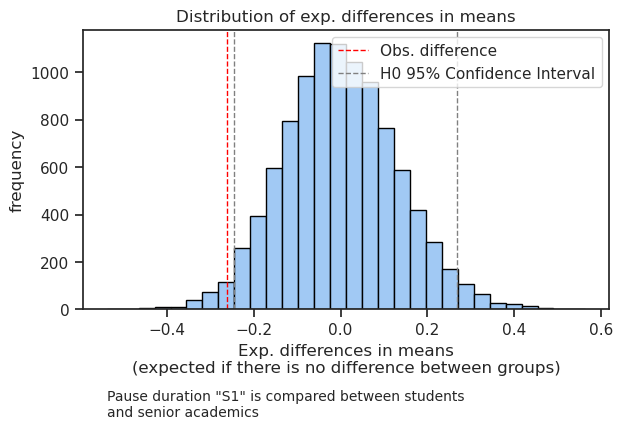

______________
S2
Статистика Хи-квадрат: 2.0405911845972217e-27
P-значение: 1.0
Observed difference (standardized): 0.4005213069271152
CI for observed difference [-1.5350096717061987, 2.336052285560429]
Cohen's d (effect size): 0.40558470530471835
Expected mean diffs are not normal distributed
Mann-Whitneyu p_value: 0.0081
Нормальность средних разниц: p=0.0156
Хи квадрат дисперсии разниц: p=1.0000
P-значение для разницы средних: 0.0073
П-значение для разницы дисперсий: 0.0979
Доверительный интервал для средней разницы H0: (-0.2801, 0.2922)
Эффект (Cohen's D): 0.4056


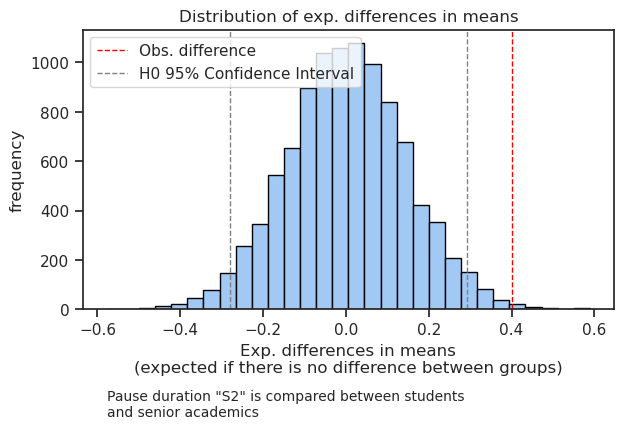

______________
S3
Статистика Хи-квадрат: 4.493248871331922e-27
P-значение: 1.0
Observed difference (standardized): -0.030567783375676134
CI for observed difference [-1.9964966901048304, 1.9353611233534782]
Cohen's d (effect size): -0.030475596147576972
Expected mean diffs are not normal distributed
Mann-Whitneyu p_value: 0.3882
Нормальность средних разниц: p=0.0108
Хи квадрат дисперсии разниц: p=1.0000
P-значение для разницы средних: 0.7535
П-значение для разницы дисперсий: 0.6992
Доверительный интервал для средней разницы H0: (-0.1798, 0.1861)
Эффект (Cohen's D): -0.0305


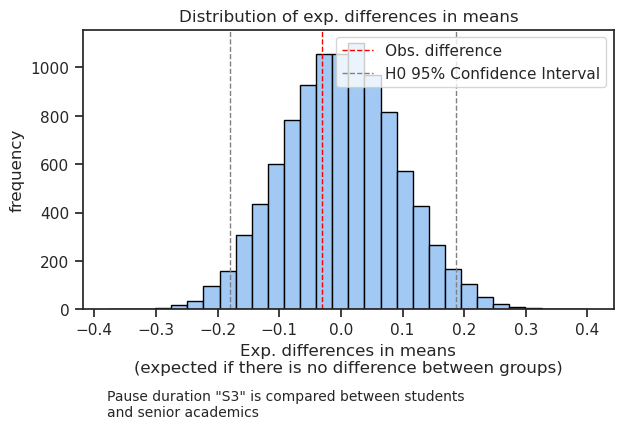

______________
S4
Статистика Хи-квадрат: 1.9613062113019456e-27
P-значение: 1.0
Observed difference (standardized): 0.05623744392880273
CI for observed difference [-1.9049440345251047, 2.0174189223827104]
Cohen's d (effect size): 0.05620356469374229
Expected mean diffs are not normal distributed
Mann-Whitneyu p_value: 0.7999
Нормальность средних разниц: p=0.0037
Хи квадрат дисперсии разниц: p=1.0000
P-значение для разницы средних: 0.2726
П-значение для разницы дисперсий: 0.5104
Доверительный интервал для средней разницы H0: (-0.1030, 0.0988)
Эффект (Cohen's D): 0.0562


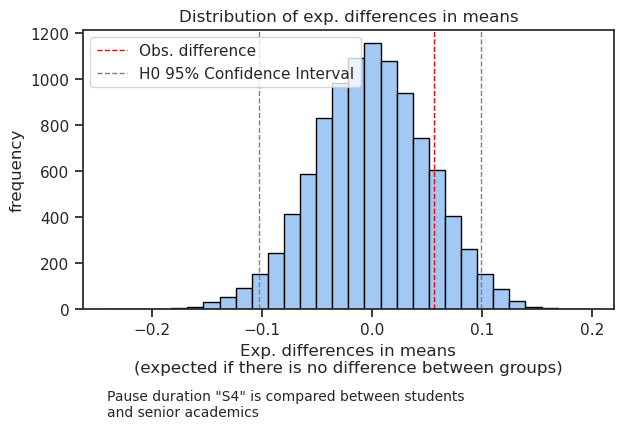

______________


In [73]:
pval = []
# es = []
pval_st = []
normality = []
dfj_boot = pd.DataFrame(columns=['type','Word frequency', 'Pause duration'])
for i in st_paper_n_list:
    print (i)
    tempdf = dfj_s[dfj_s['strategy_paper_name']==i]
    #
    # p_value_mean, normal, pst = full_bootstrap_analysis(tempdf, 'Pause duration')
    mean_expected_diffs, normal, ci_mean, delta ,cohens_d, p_value_mean, Crit_metric, pst = full_bootstrap_analysis(tempdf, 'Pause duration')
    plot_bresults(mean_expected_diffs, delta, ci_mean, i, text_add="Pause duration ")
    paper_table.loc[len(paper_table)] = [f'Pause duration of {i}', normal, [round(x, 2) for x in ci_mean]
                                         , round(delta, 2), round(cohens_d, 2)
                                         , round(p_value_mean, 4), round(Crit_metric, 2), round(pst, 4)]
    dfj_boot = pd.concat([dfj_boot, tempdf])
    pval.append(p_value_mean)
    # es.append(cohens_d)
    pval_st.append(pst)
    normality.append(normal)
    print('______________')

In [73]:
# conf_interval = []
# pval = []
# es = []
# dfj_boot = pd.DataFrame(columns=['type','Word frequency', 'Pause duration'])
# for i in sorted(dfj_s['strategy_paper_name'].unique()):
#     if i!='0':
#         print(i)
#         tempdf = dfj_s[dfj_s['strategy_paper_name']==i]
#         ci, p_value, observed_diff, mdelta_, cohens_d = full_bootstrap_mean_diff(tempdf, 'Pause duration', f'Strategy "{i}".\n')
#         dfj_boot = pd.concat([dfj_boot, tempdf])
#         conf_interval.append(ci)
#         pval.append(p_value)
#         es.append(cohens_d)
#         print('\n')

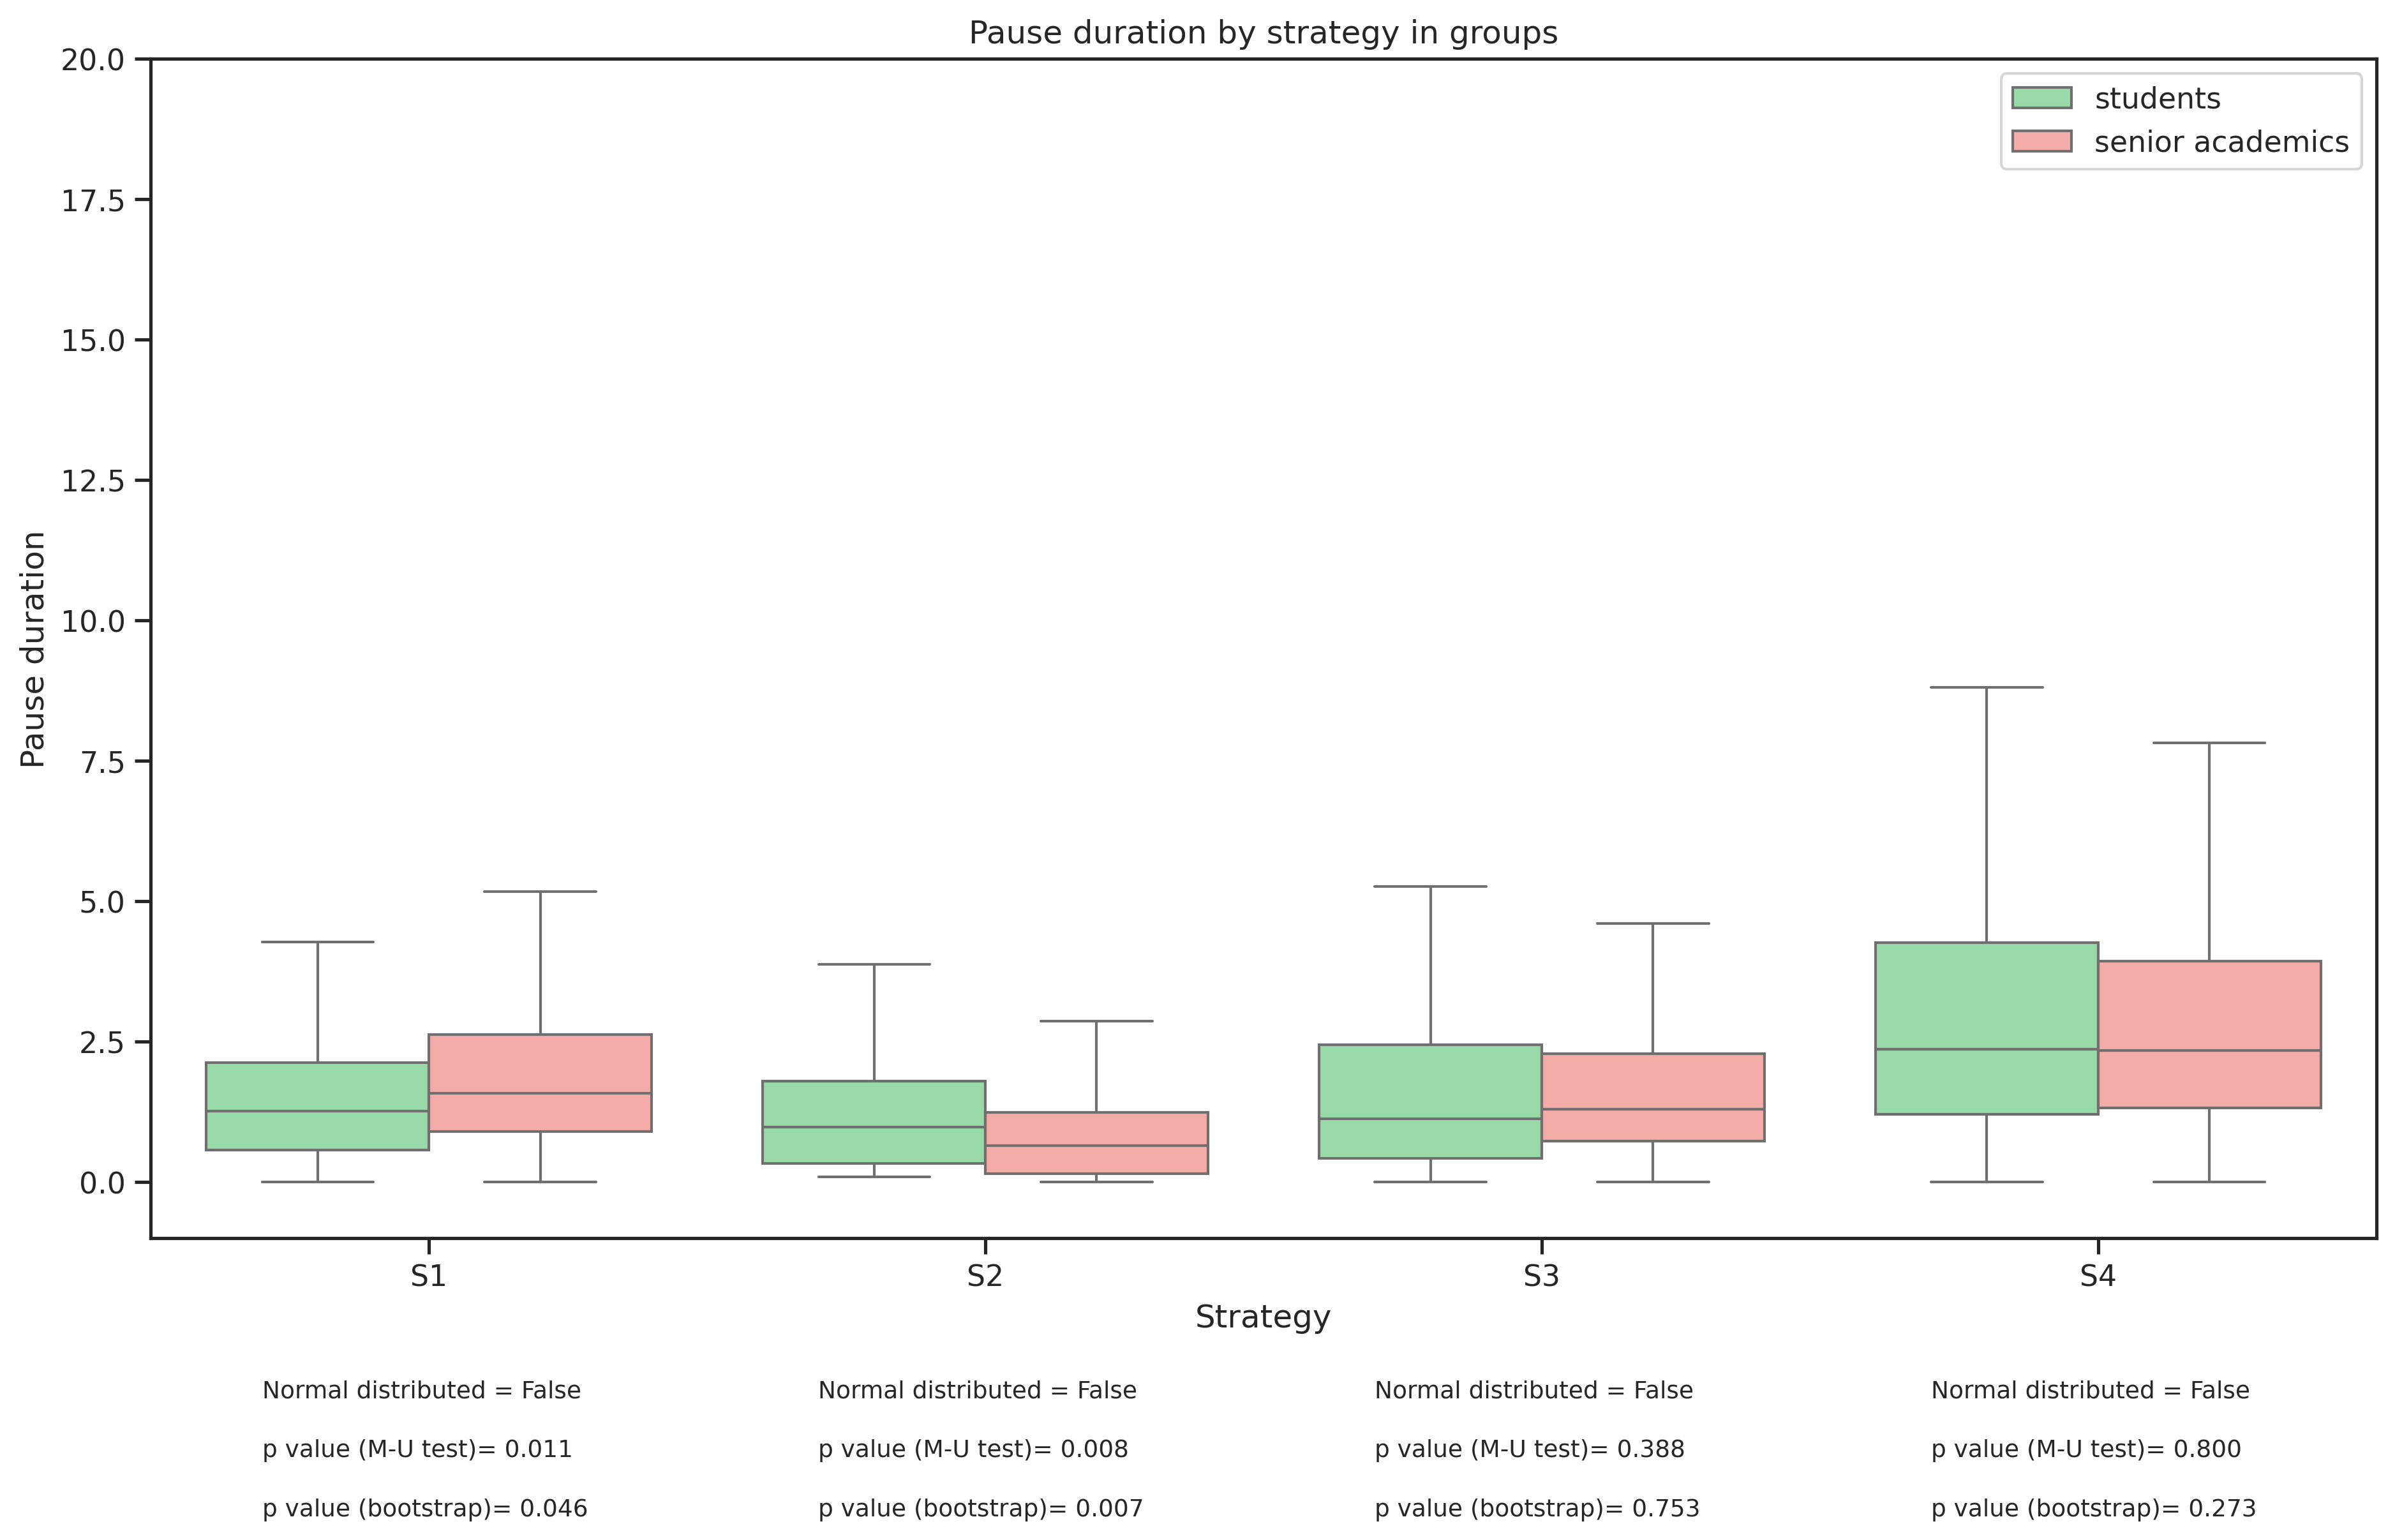

In [74]:
sns.set_theme(style="ticks", palette="pastel");
fig, axs = plt.subplots(figsize=(15, 8), dpi=300)
# plt.figure(figsize=(10, 6))
g = sns.boxplot(data = dfj_boot.sort_values(['strategy_paper_name']), x='strategy_paper_name',y='Pause duration', hue='type', palette={'senior academics':'r', 'students':'g'}, showfliers = False);
plt.ylim(-1, 20)

# ax.text(0.02, 1.05, f"p value = {pval[j]:.3f}", ha="left", va="top", transform=ax.transAxes)
for i in range(len(normality)):
      g.text(i*0.25+0.05, -0.12, f"Normal distributed = {str(normality[i])}", rotation = 0, fontsize = 9, ha="left", va="top", transform=g.transAxes )         # Size
      if normality[i]:
            g.text(i*0.25+0.05, -0.17, f"p value (t-test with permutation)= {pval_st[i]:.3f}", rotation = 0, fontsize = 9, ha="left", va="top", transform=g.transAxes )
      else:
            g.text(i*0.25+0.05, -0.17, f"p value (M-U test)= {pval_st[i]:.3f}", rotation = 0, fontsize = 9, ha="left", va="top", transform=g.transAxes )
      g.text(i*0.25+0.05, -0.22, f"p value (bootstrap)= {pval[i]:.3f}", fontsize = 9 , ha="left", va="top", transform=g.transAxes)
    
g.legend( bbox_to_anchor=(1, 1))
plt.xlabel('Strategy')
plt.title('Pause duration by strategy in groups')
fig.savefig(f'figures/Pause duration by strategy in groups.png', bbox_inches='tight')

In [75]:
dict_for_strategy_names_paper = {'phonetic strategy': 'S1',
                                 'derivative strategy': 'S2',
                                 'semantic-field strategy': 'S3',
                                 'individual association strategy': 'S4'
}

## word frequency

In [86]:
# ci, p_value, observed_diff, mdelta_, cohens_d = full_bootstrap_mean_diff(dfj[['type','Word frequency']], 'Word frequency')

### **between strategies**

In [76]:
dfj_s = dfjj[['type','Word frequency']]

In [120]:
# full_bootstrap_mean_diff(dfj_s, 'Word frequency', f'Strategy "{i}".\n')

In [77]:
st_paper_n_list = sorted(dfjj['strategy_paper_name'].unique())
st_paper_n_list

['S1', 'S2', 'S3', 'S4']

S1
Статистика Хи-квадрат: 2.6494116827830708e-27
P-значение: 1.0
Observed difference (standardized): 0.058784918827033183
CI for observed difference [-1.912449693423513, 2.0300195310775795]
Cohen's d (effect size): 0.0584498872863443
Expected mean diffs are not normal distributed
Mann-Whitneyu p_value: 0.1934
Нормальность средних разниц: p=0.0161
Хи квадрат дисперсии разниц: p=1.0000
P-значение для разницы средних: 0.6617
П-значение для разницы дисперсий: 0.9893
Доверительный интервал для средней разницы H0: (-0.2476, 0.2580)
Эффект (Cohen's D): 0.0584


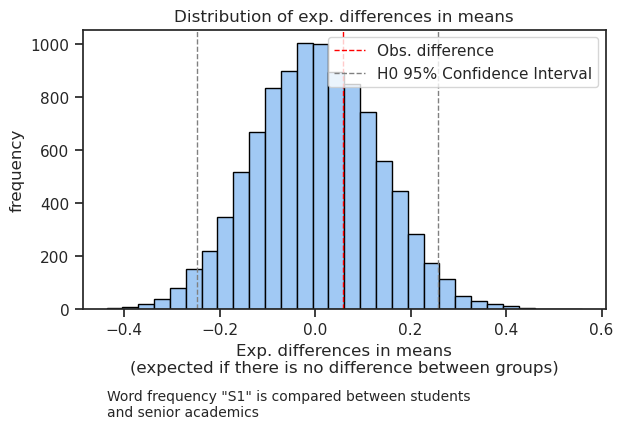

______________
S2
Статистика Хи-квадрат: 1.6619646385082222e-28
P-значение: 1.0
Observed difference (standardized): 0.26884649136897343
CI for observed difference [-1.6889868377683779, 2.226679820506325]
Cohen's d (effect size): 0.26914401509109287
Expected mean diffs are normal distributed
T-student p_value: 0.0622
Нормальность средних разниц: p=0.7937
Хи квадрат дисперсии разниц: p=1.0000
P-значение для разницы средних: 0.0646
П-значение для разницы дисперсий: 0.3284
Доверительный интервал для средней разницы H0: (-0.2856, 0.2868)
Эффект (Cohen's D): 0.2691


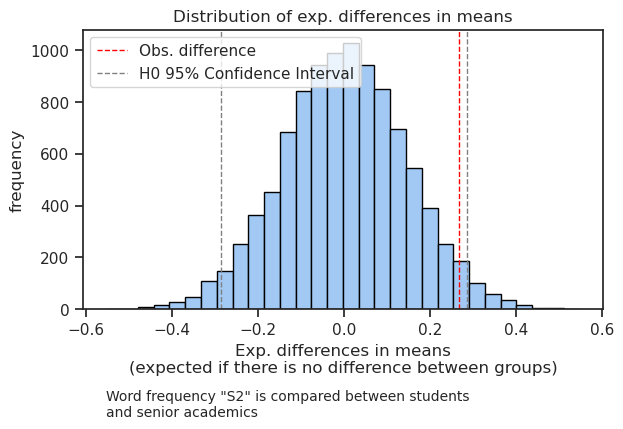

______________
S3
Статистика Хи-квадрат: 2.4561544084109042e-27
P-значение: 1.0
Observed difference (standardized): 0.15903940245903722
CI for observed difference [-1.80117443628191, 2.1192532411999845]
Cohen's d (effect size): 0.1590220529306793
Expected mean diffs are normal distributed
T-student p_value: 0.0870
Нормальность средних разниц: p=0.1147
Хи квадрат дисперсии разниц: p=1.0000
P-значение для разницы средних: 0.0882
П-значение для разницы дисперсий: 0.3826
Доверительный интервал для средней разницы H0: (-0.1823, 0.1842)
Эффект (Cohen's D): 0.1590


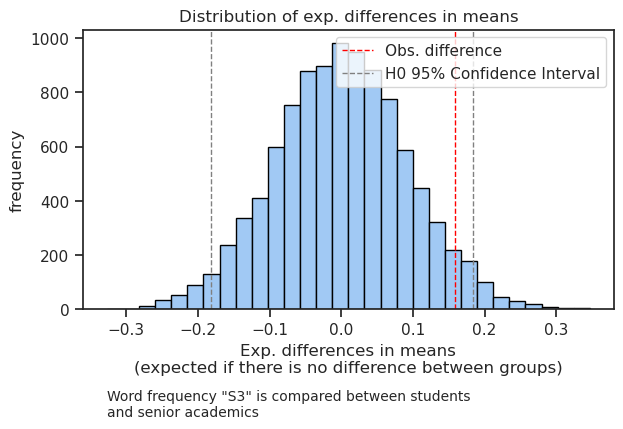

______________
S4
Статистика Хи-квадрат: 2.8400767673088764e-27
P-значение: 1.0
Observed difference (standardized): 0.13023920842930364
CI for observed difference [-1.8275914042037429, 2.08806982106235]
Cohen's d (effect size): 0.13038352085941146
Expected mean diffs are normal distributed
T-student p_value: 0.0116
Нормальность средних разниц: p=0.7122
Хи квадрат дисперсии разниц: p=1.0000
P-значение для разницы средних: 0.0122
П-значение для разницы дисперсий: 0.1827
Доверительный интервал для средней разницы H0: (-0.0989, 0.1021)
Эффект (Cohen's D): 0.1304


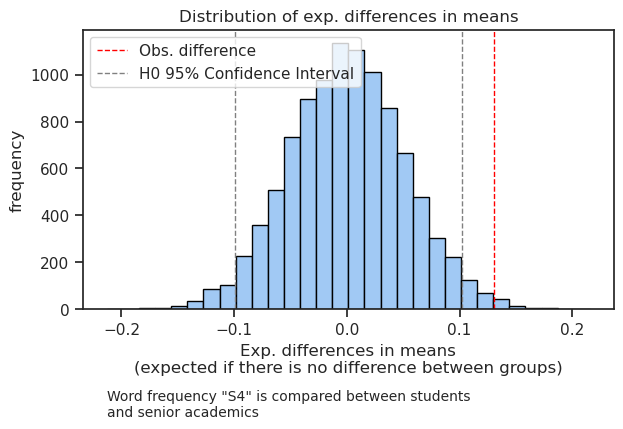

______________


In [80]:
pval = []
# es = []
pval_st = []
normality = []
dfj_boot = dfjj[['type', 'Word frequency', 'strategy_paper_name']]
for i in st_paper_n_list:
    print (i)
    tempdf = dfj_boot[dfj_boot['strategy_paper_name']==i]
    
    mean_expected_diffs, normal, ci_mean, delta ,cohens_d, p_value_mean, Crit_metric, pst = full_bootstrap_analysis(tempdf, 'Word frequency')
    plot_bresults(mean_expected_diffs, delta, ci_mean, i, text_add="Word frequency ")
    paper_table.loc[len(paper_table)] = [f'Word frequency of {i}', normal, [round(x, 2) for x in ci_mean]
                                         , round(delta, 2), round(cohens_d, 2)
                                         , round(p_value_mean, 4), round(Crit_metric, 2), round(pst, 4)]
    pval.append(p_value_mean)
    # es.append(cohens_d)
    pval_st.append(pst)
    normality.append(normal)
    print('______________')

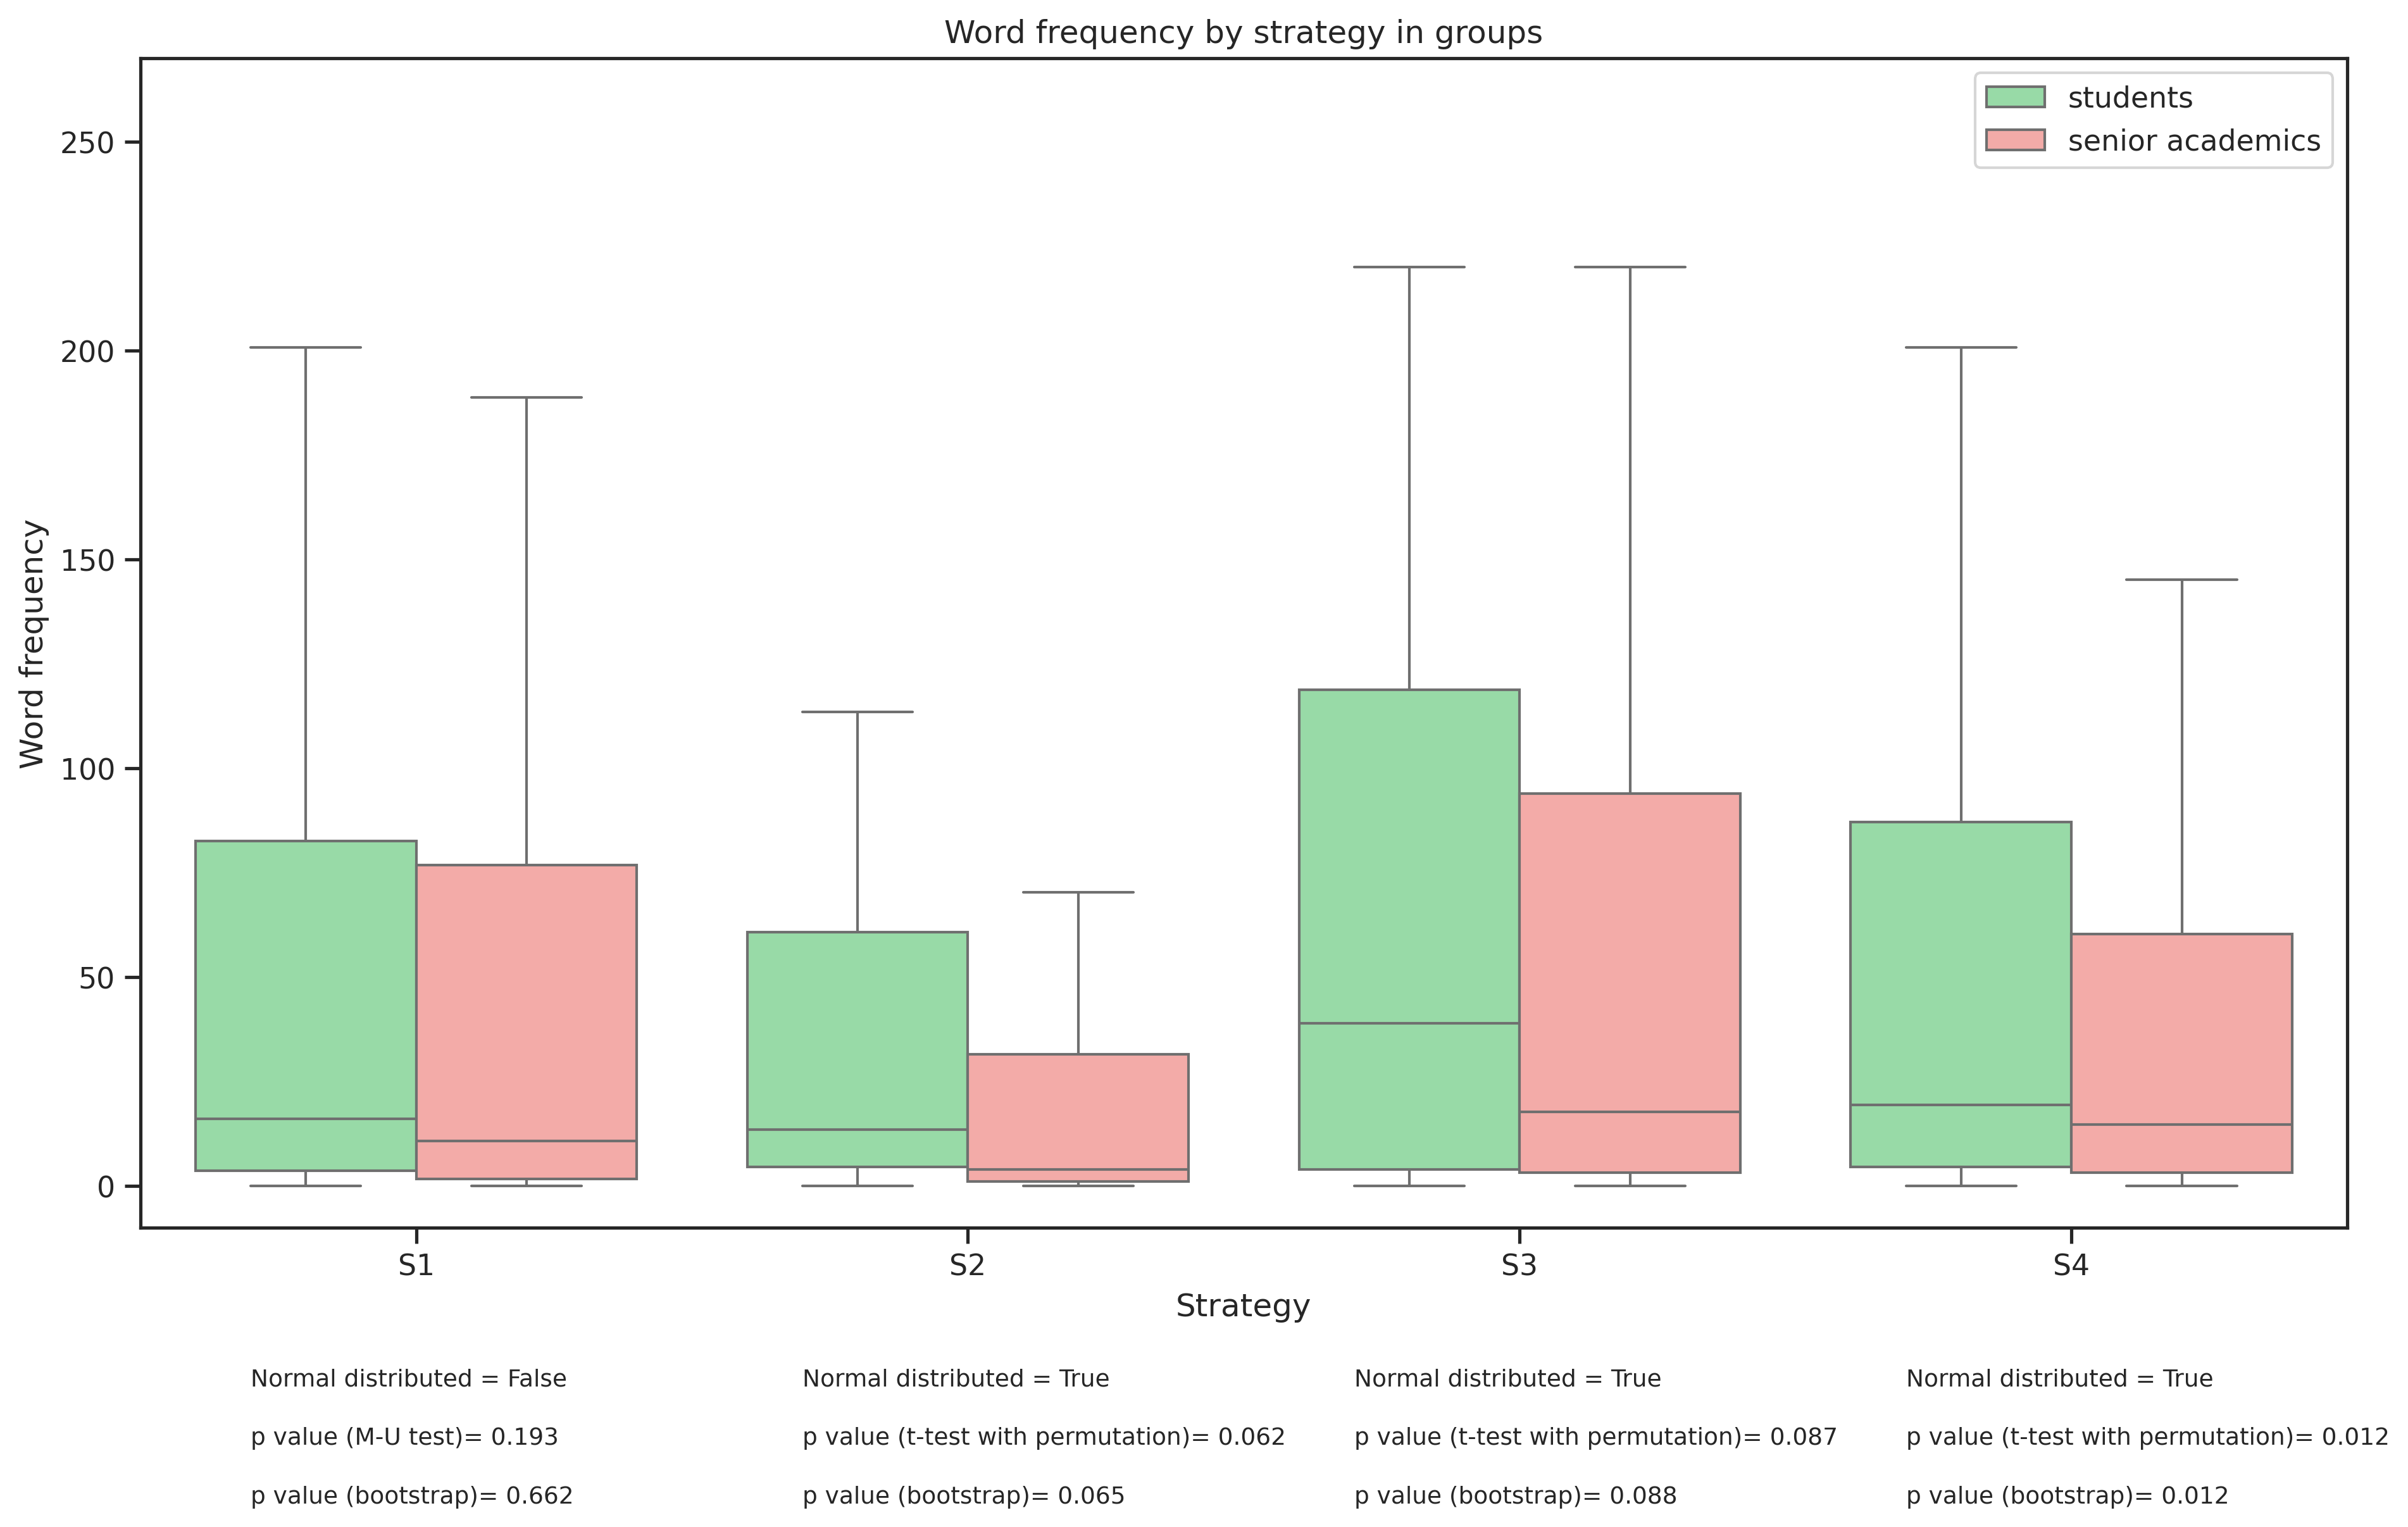

In [82]:
sns.set_theme(style="ticks", palette="pastel");
fig, axs = plt.subplots(figsize=(15, 8), dpi=300)
# plt.figure(figsize=(10, 6))
g = sns.boxplot(data = dfj_boot.sort_values(['strategy_paper_name']), x='strategy_paper_name',y='Word frequency', hue='type', palette={'senior academics':'r', 'students':'g'}, showfliers = False);
plt.ylim((-10,270))

# ax.text(0.02, 1.05, f"p value = {pval[j]:.3f}", ha="left", va="top", transform=ax.transAxes)
for i in range(len(normality)):
      g.text(i*0.25+0.05, -0.12, f"Normal distributed = {str(normality[i])}", rotation = 0, fontsize = 9, ha="left", va="top", transform=g.transAxes )         # Size
      if normality[i]:
            g.text(i*0.25+0.05, -0.17, f"p value (t-test with permutation)= {pval_st[i]:.3f}", rotation = 0, fontsize = 9, ha="left", va="top", transform=g.transAxes )
      else:
            g.text(i*0.25+0.05, -0.17, f"p value (M-U test)= {pval_st[i]:.3f}", rotation = 0, fontsize = 9, ha="left", va="top", transform=g.transAxes )
      g.text(i*0.25+0.05, -0.22, f"p value (bootstrap)= {pval[i]:.3f}", fontsize = 9 , ha="left", va="top", transform=g.transAxes)
    
g.legend( bbox_to_anchor=(1, 1))
plt.xlabel('Strategy')
plt.title('Word frequency by strategy in groups')
fig.savefig(f'figures/Word frequency by strategy in groups.png', bbox_inches='tight')

In [126]:
# fig = plt.figure(figsize=(10, 6), dpi=300)
# sns.set_theme(style="ticks", palette="pastel")
# g = sns.boxplot(data = dfj_boot.sort_values(['strategy_paper_name']), x='strategy_paper_name',y='Word frequency', hue='type', palette={'senior academics':'r', 'students':'g'}, fliersize=3);
# plt.tight_layout()
# g.legend( bbox_to_anchor=(1.28, 1))
# plt.ylim((-10,270))

# for i in range(len(es)):
#       a = dfj_boot[(dfj_boot['type']!='students') & (dfj_boot['strategy_paper_name']==st_paper_n_list[i])]['Word frequency' + '_standardized'].values
#       b = dfj_boot[(dfj_boot['type']=='students') & (dfj_boot['strategy_paper_name']==st_paper_n_list[i])]['Word frequency' + '_standardized'].values
#       # T, pst = stats.ttest_ind(a, b, equal_var=False, permutations=10000)
#       T, pst = stats.ttest_ind(a, b, equal_var=False, permutations=10000)

#       g.text(i*0.25+0.05, -0.12, f"ES = {es[i]:.2f}", rotation = 0, fontsize = 9, ha="left", va="top", transform=g.transAxes )         # Size
#       g.text(i*0.25+0.05, -0.17, f"p value = {pval[i]:.3f}", rotation = 0, fontsize = 9, ha="left", va="top", transform=g.transAxes )
#       g.text(i*0.25+0.05, -0.22, f"p value (t test)= {pst:.3f}", rotation = 0, fontsize = 9, ha="left", va="top", transform=g.transAxes )
    
# g.legend( bbox_to_anchor=(0.75, 0.85))
# # fig.suptitle('Word frequency by strategy in groups', fontsize=15)
# g.set_title('Word frequency by strategy in groups', fontdict={'fontsize': 15, 'fontweight': 'medium'})
# plt.xlabel('strategy_name')
# plt.show()

# RT

In [83]:
rt = pd.read_csv('results_academic_student.csv', sep=';' )
rt.head()

,participant,mean_rt,group
0,12014,0.608103,senior academics
1,2001,0.537719,senior academics
2,2005,0.863233,senior academics
3,9001,0.801409,senior academics
4,9002,0.564224,senior academics


In [84]:
# rt_full = pd.read_csv('combined_shape_trials.csv', dtype = {'participant': 'str', 'accuracy' : 'float', 'rt':'float'})
rt_full = pd.read_csv('combined_shape_trials.csv')
rt_full['participant'] = pd.to_numeric(rt_full['participant'], downcast='integer')
rt_full = rt_full[(rt_full['accuracy']==1 ) & (~rt_full['participant'].isna())]
# rt_full['participant']= rt_full['participant'].fillna(0).astype('int64')
rt_full['participant']= rt_full['participant'].astype('int64')
rt_full = rt_full.merge(rt[['group', 'participant']], on='participant', how='inner')
rt_full.head(2)


,participant,accuracy,rt,group
0,12001,1,1.053446,senior academics
1,12001,1,1.504920,senior academics


In [85]:
rt_full['participant'].nunique()

46

Статистика Хи-квадрат: 3.709652703515811e-27
P-значение: 1.0
Observed difference (standardized): -0.49768749012000635
CI for observed difference [-2.457911355217492, 1.4625363749774793]
Cohen's d (effect size): -0.4976306522962879
Expected mean diffs are normal distributed
T-student p_value: 0.0913
Нормальность средних разниц: p=0.5573
Хи квадрат дисперсии разниц: p=1.0000
P-значение для разницы средних: 0.0830
П-значение для разницы дисперсий: 0.8622
Доверительный интервал для средней разницы H0: (-0.5721, 0.5682)
Эффект (Cohen's D): -0.4976


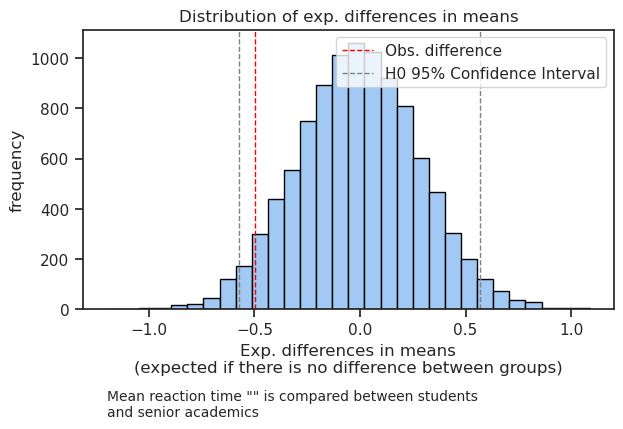

In [86]:
mean_expected_diffs, normal, ci_mean, delta ,cohens_d, p_value_mean, Crit_metric, pst = full_bootstrap_analysis(rt, 'mean_rt', type_col='group')
plot_bresults(mean_expected_diffs, delta, ci_mean, col='', text_add="Mean reaction time ")

paper_table.loc[len(paper_table)] = ['Mean reaction time', normal, [round(x, 2) for x in ci_mean]
                                         , round(delta, 2), round(cohens_d, 2)
                                         , round(p_value_mean, 4), round(Crit_metric, 2), round(pst, 4)]

In [87]:
a = rt[(rt['group']!='students')]['mean_rt' + '_standardized'].values
b = rt[(rt['group']=='students')]['mean_rt' + '_standardized'].values
T_o , p_ond = stats.ttest_ind(a, b, permutations=1000, alternative='greater')

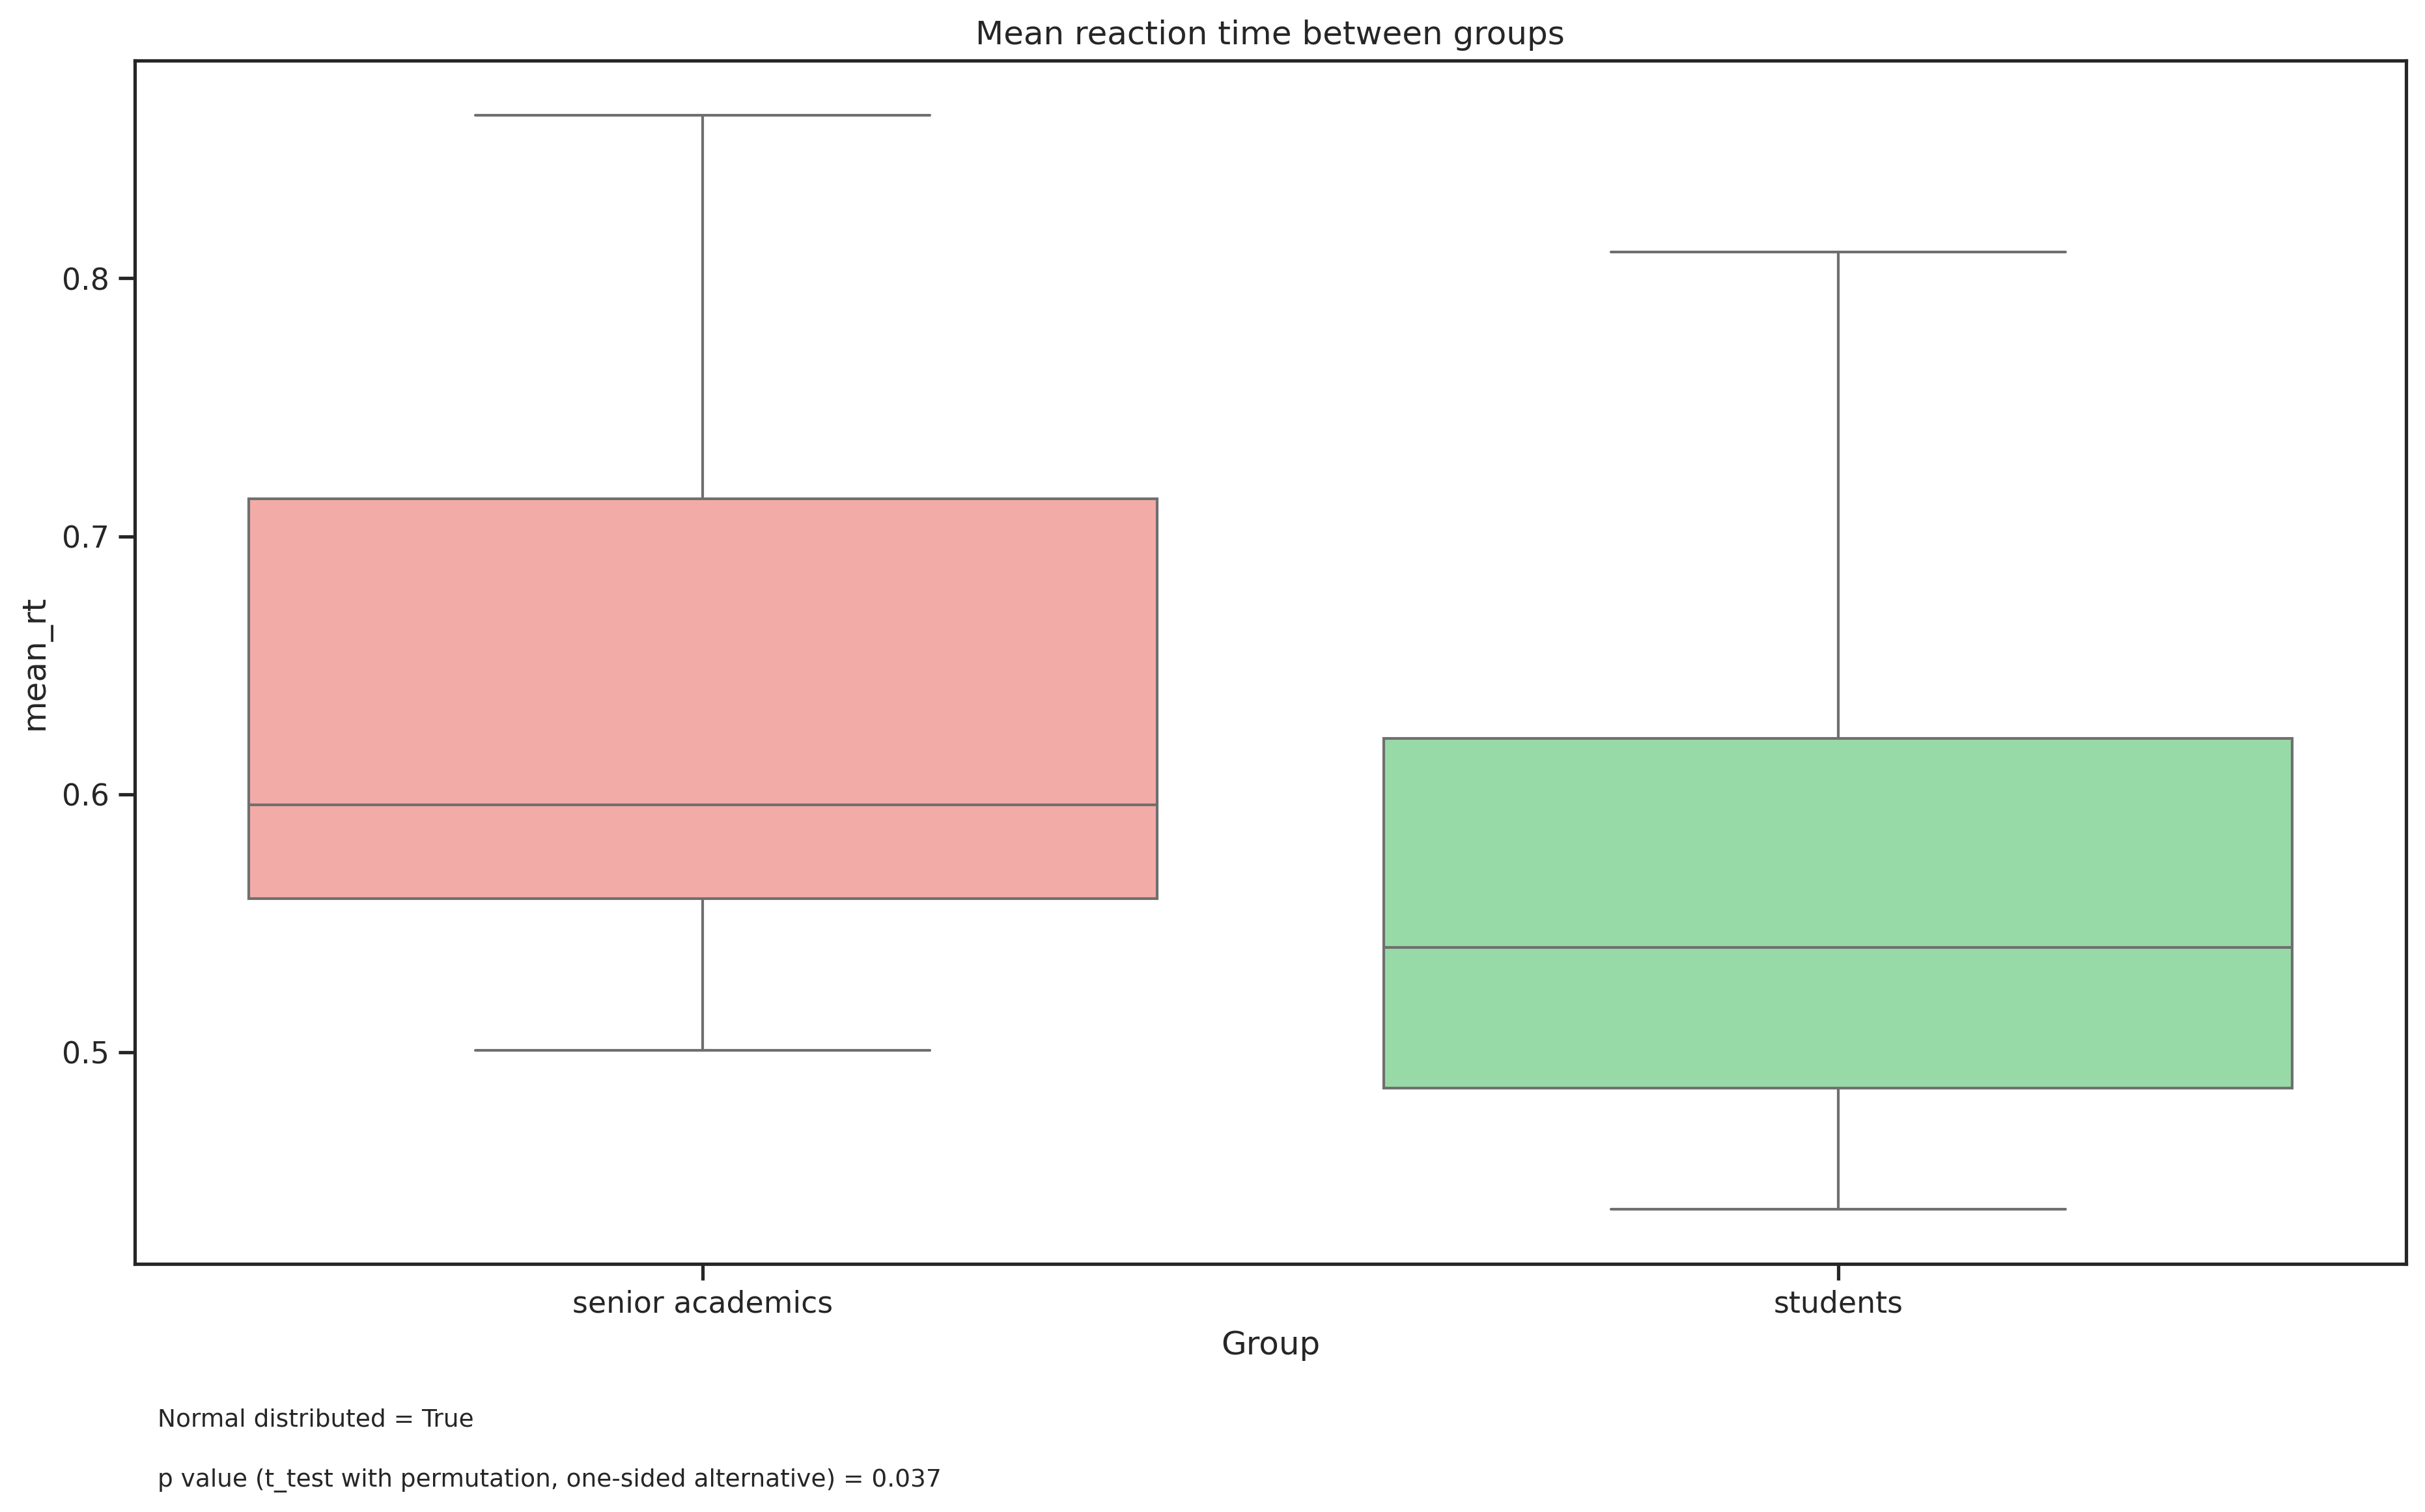

In [89]:
sns.set_theme(style="ticks", palette="pastel");
fig, axs = plt.subplots(figsize=(15, 8), dpi=300)
# plt.figure(figsize=(10, 6))
g = sns.boxplot(data = rt, y='mean_rt', x='group', hue='group', palette={'senior academics':'r', 'students':'g'}, showfliers = False);
g.text(0.01, -0.12, f"Normal distributed = {str(normal)}", rotation = 0, fontsize = 9, ha="left", va="top", transform=g.transAxes )         # Size
if 1:
      g.text(0.01
             , -0.17, f"p value (t_test with permutation, one-sided alternative) = {p_ond:.3f}", rotation = 0, fontsize = 9, ha="left", va="top", transform=g.transAxes )
      
# g.text(0.01, -0.22, f"p value (bootstrap)= {p_value_mean:.3f}", fontsize = 9 , ha="left", va="top", transform=g.transAxes)
    
plt.xlabel('Group')
plt.title('Mean reaction time between groups')
fig.savefig(f'figures/Mean reaction time between groups one-sided.png', bbox_inches='tight')

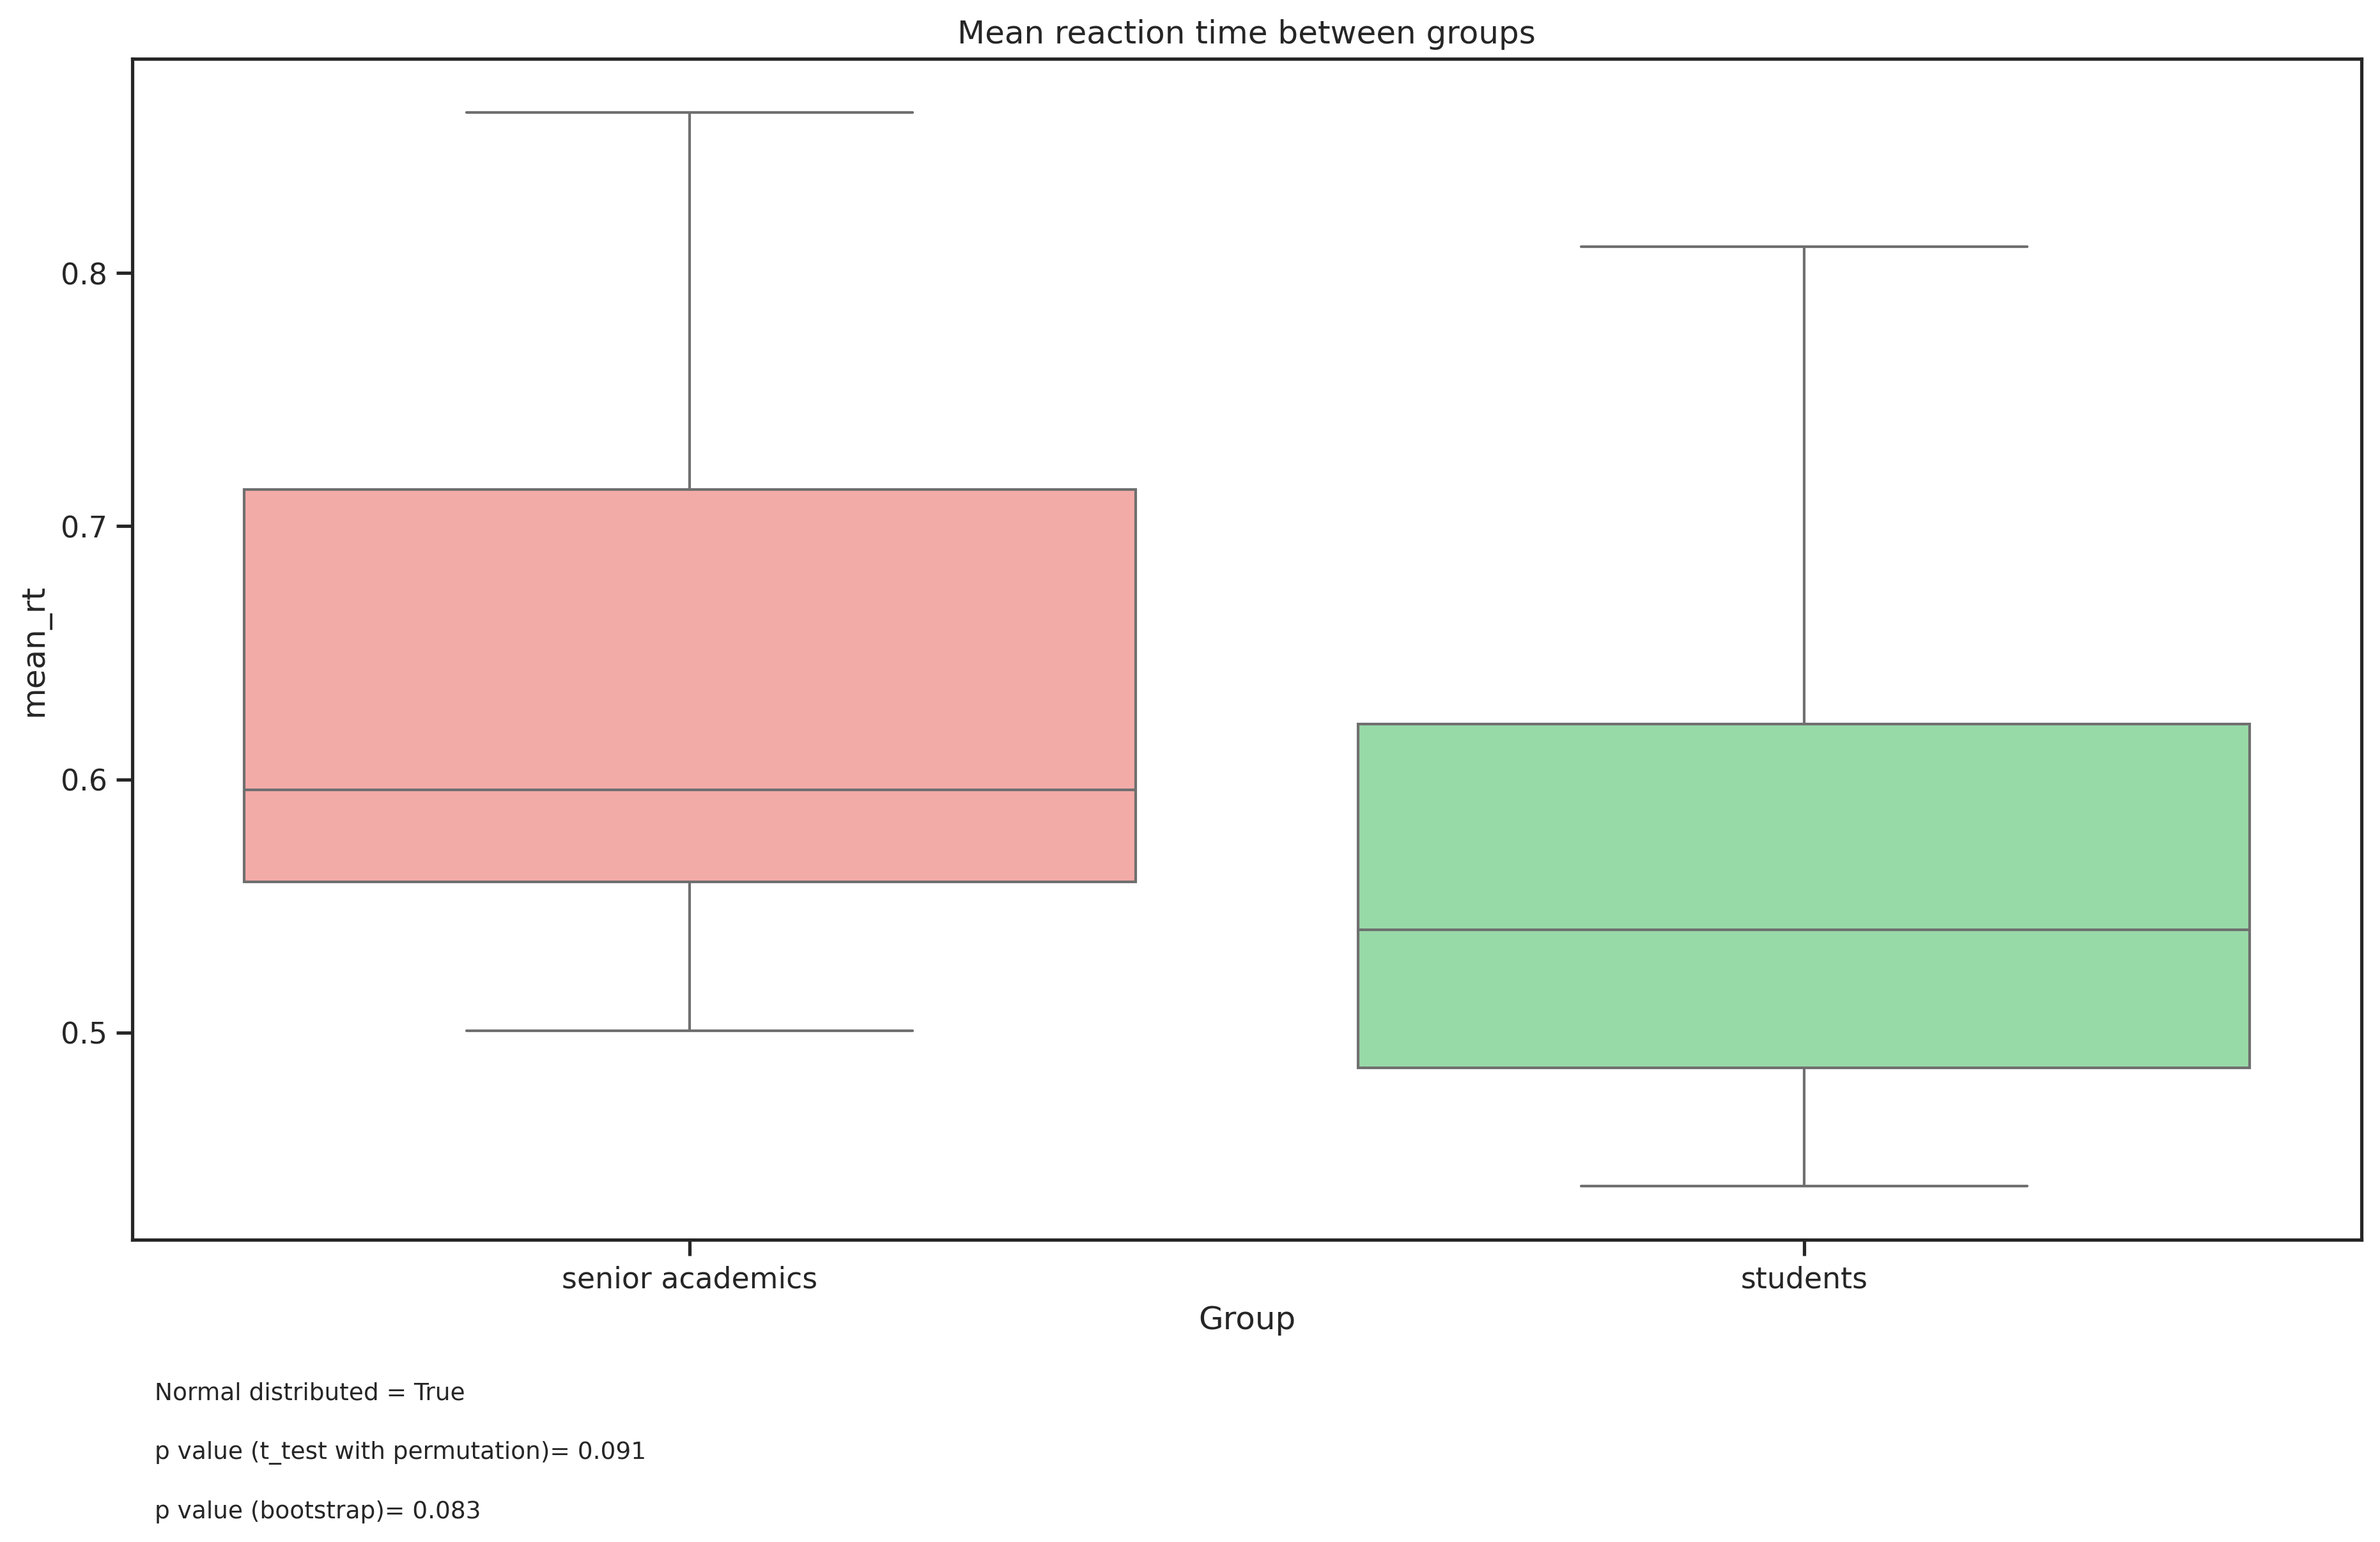

In [90]:
sns.set_theme(style="ticks", palette="pastel");
fig, axs = plt.subplots(figsize=(15, 8), dpi=300)
# plt.figure(figsize=(10, 6))
g = sns.boxplot(data = rt, y='mean_rt', x='group', hue='group', palette={'senior academics':'r', 'students':'g'}, showfliers = False);
g.text(0.01, -0.12, f"Normal distributed = {str(normal)}", rotation = 0, fontsize = 9, ha="left", va="top", transform=g.transAxes )         # Size
if 1:
      g.text(0.01
             , -0.17, f"p value (t_test with permutation)= {pst:.3f}", rotation = 0, fontsize = 9, ha="left", va="top", transform=g.transAxes )
else:
      g.text(-0.25-0.05, -0.17, f"p value (M-U test)= {pst:.3f}", rotation = 0, fontsize = 9, ha="left", va="top", transform=g.transAxes )
g.text(0.01, -0.22, f"p value (bootstrap)= {p_value_mean:.3f}", fontsize = 9 , ha="left", va="top", transform=g.transAxes)
    
plt.xlabel('Group')
plt.title('Mean reaction time between groups')
fig.savefig(f'figures/Mean reaction time between groups.png', bbox_inches='tight')

Статистика Хи-квадрат: 2.581605734208281e-27
P-значение: 1.0
Observed difference (standardized): -0.2720814053363973
CI for observed difference [-2.215534689022011, 1.6713718783492162]
Cohen's d (effect size): -0.27439792812925967
Expected mean diffs are normal distributed
T-student p_value: 0.0001
Нормальность средних разниц: p=0.1049
Хи квадрат дисперсии разниц: p=1.0000
P-значение для разницы средних: 0.0000
П-значение для разницы дисперсий: 0.3881
Доверительный интервал для средней разницы H0: (-0.0939, 0.0914)
Эффект (Cohen's D): -0.2744


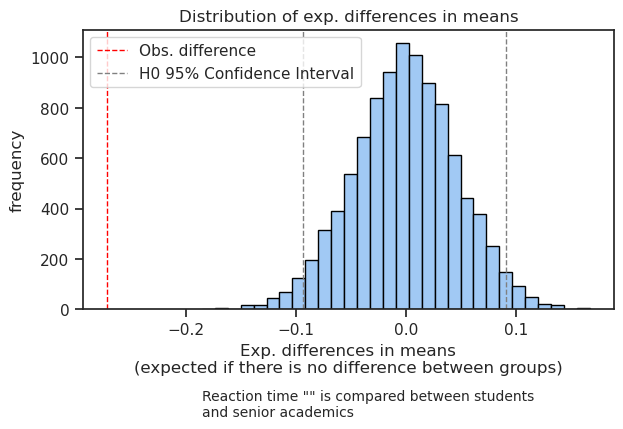

In [91]:
mean_expected_diffs, normal, ci_mean, delta ,cohens_d, p_value_mean, Crit_metric, pst = full_bootstrap_analysis(rt_full, 'rt', type_col='group')
plot_bresults(mean_expected_diffs, delta, ci_mean, col='', text_add="Reaction time ")

paper_table.loc[len(paper_table)] = ['Reaction time', normal, [round(x, 2) for x in ci_mean]
                                         , round(delta, 2), round(cohens_d, 2)
                                         , round(p_value_mean, 4), round(Crit_metric, 2), round(pst, 4)]

# p_value_mean, normal, pst = full_bootstrap_analysis(rt_full, 'rt', type_col='group')

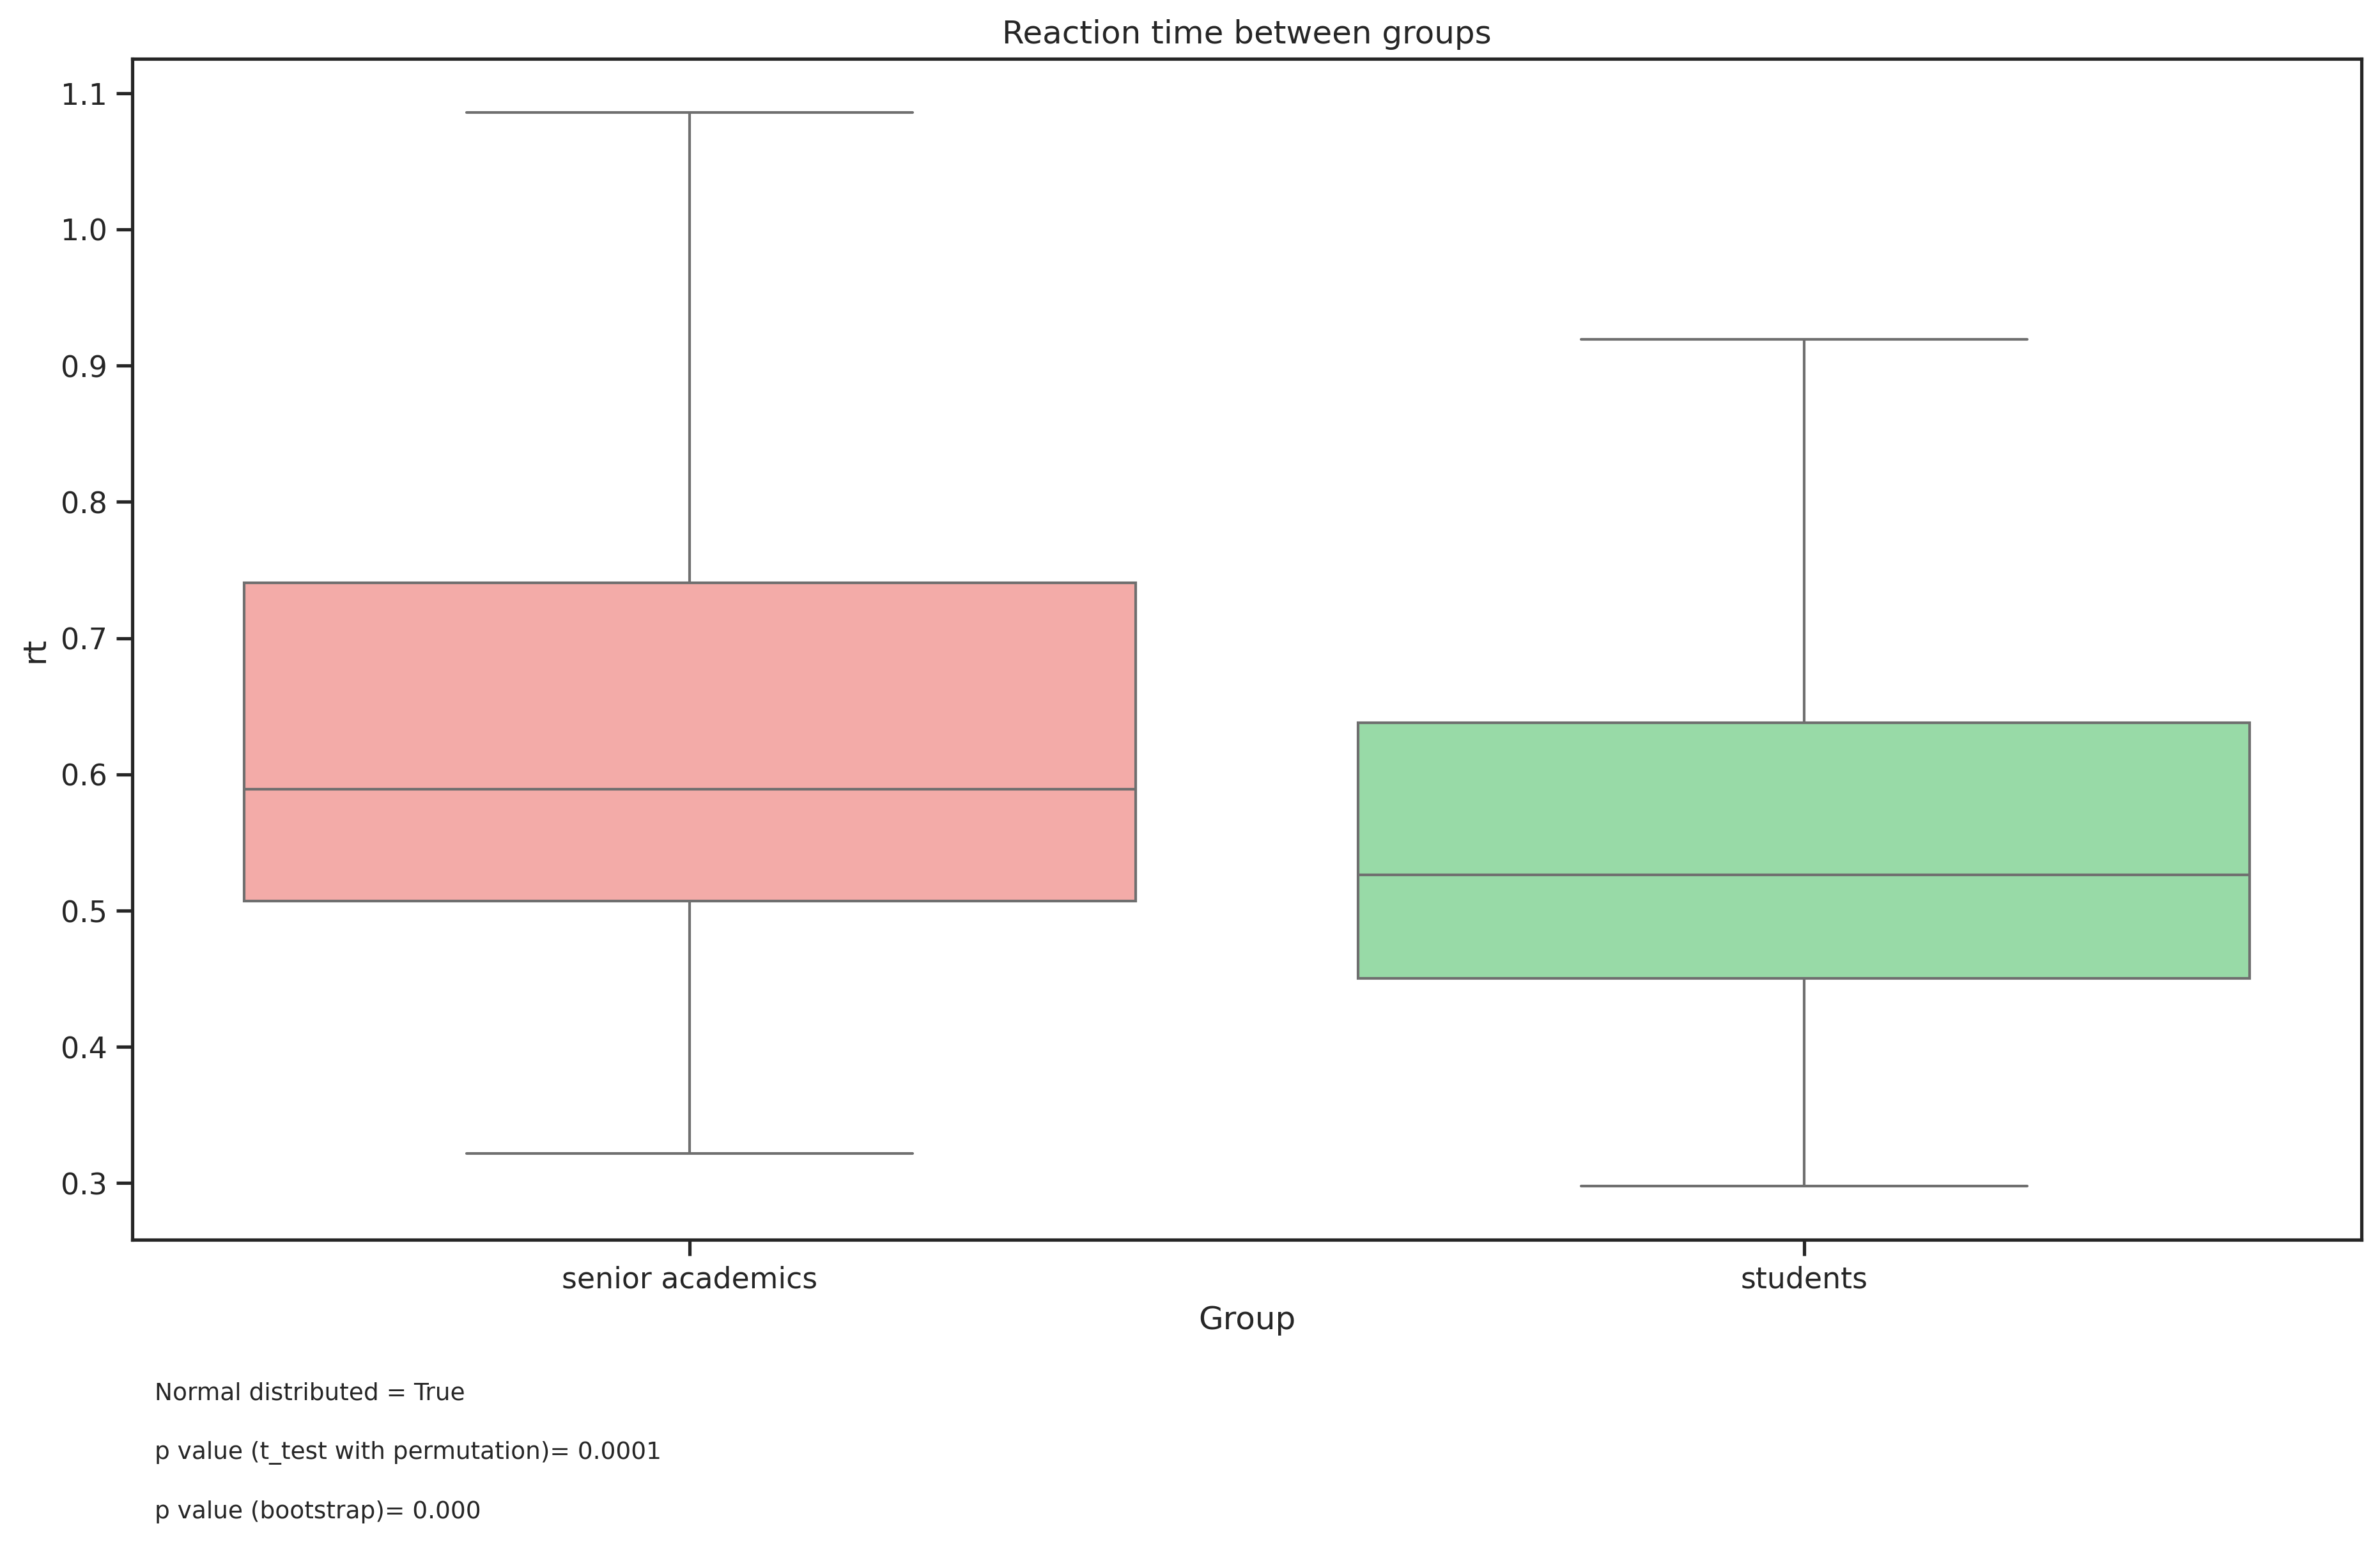

In [92]:
sns.set_theme(style="ticks", palette="pastel");
fig, axs = plt.subplots(figsize=(15, 8), dpi=300)
# plt.figure(figsize=(10, 6))
g = sns.boxplot(data = rt_full, y='rt', x='group', hue='group', palette={'senior academics':'r', 'students':'g'}, showfliers = False);
g.text(0.01, -0.12, f"Normal distributed = {str(normal)}", rotation = 0, fontsize = 9, ha="left", va="top", transform=g.transAxes )         # Size
if 1:
      g.text(0.01
             , -0.17, f"p value (t_test with permutation)= {pst:.4f}", rotation = 0, fontsize = 9, ha="left", va="top", transform=g.transAxes )
else:
      g.text(-0.25-0.05, -0.17, f"p value (M-U test)= {pst:.3f}", rotation = 0, fontsize = 9, ha="left", va="top", transform=g.transAxes )
g.text(0.01, -0.22, f"p value (bootstrap)= {p_value_mean:.3f}", fontsize = 9 , ha="left", va="top", transform=g.transAxes)
    
plt.xlabel('Group')
plt.title('Reaction time between groups')
fig.savefig(f'figures/Reaction time between groups.png', bbox_inches='tight')

In [90]:
# conf_interval = []
# pval = []
# es = []
# rt.columns = ['participant', 'mean_rt', 'type']

# # print(i)
# ci, p_value, observed_diff, mdelta_, cohens_d = full_bootstrap_mean_diff(rt, 'mean_rt')
# conf_interval.append(ci)
# pval.append(p_value)
# es.append(cohens_d)
# print('\n')

# RT correlation

In [ ]:
# rt = pd.read_csv('results_academic_student.csv', sep=';')
# rt.head()

,participant,mean_rt,group
0,12014,0.608103,senior academics
1,2001,0.537719,senior academics
2,2005,0.863233,senior academics
3,9001,0.801409,senior academics
4,9002,0.564224,senior academics


In [93]:
stuts = pd.read_csv('Список_студентов_психфак_мгу_весна_осень_24_2.csv', sep = '\t')
stuts['ID autumn'] = pd.to_numeric(stuts['ID autumn'], downcast='integer')
stuts['ID autumn']= stuts['ID autumn'].fillna(0).astype('int64')
stuts = stuts[['ID', 'ID autumn']]

In [94]:
academics = pd.read_excel('senior_academics_ids.xlsx')
academics['ID autumn'] = pd.to_numeric(academics['ID_new'], downcast='integer')
academics['ID autumn']= academics['ID autumn'].fillna(0).astype('int64')
# academics.head(1)
academics = academics[['ID', 'ID autumn']]

In [95]:
ids_ac_st = pd.concat([academics, stuts])
rt_ = rt.merge(ids_ac_st, left_on='participant', right_on='ID autumn', how='inner')

In [96]:
fullrt_ = rt_full.merge(ids_ac_st, left_on='participant', right_on='ID autumn', how='inner')

In [97]:
fullrt_.head(2)

,participant,accuracy,rt,group,rt_standardized,ID,ID autumn
0,12001,1,1.053446,senior academics,1.632106,pr_M_2,12001
1,12001,1,1.504920,senior academics,3.337005,pr_M_2,12001


In [98]:
rt_for_cor = dfjj[['ID', 'frequency', 'pause', 'mean pause', 'type',
       'strategy_paper_name', 'Word frequency', 'Pause duration', 'order_letter', 'order_whole_test']].merge(rt_, on='ID', how='inner')
fullrt_for_cor = dfjj[['ID', 'frequency', 'pause', 'mean pause', 'type',
       'strategy_paper_name', 'Word frequency', 'Pause duration', 'order_letter', 'order_whole_test']].merge(fullrt_, on='ID', how='inner')

In [99]:
rt_for_cor = rt_for_cor[['ID', 'mean pause', 'type', 'strategy_paper_name',
       'Word frequency', 'Pause duration', 'mean_rt', 'group',
       'mean_rt_standardized', 'order_letter', 'order_whole_test']]
fullrt_for_cor = fullrt_for_cor[['ID', 'mean pause', 'type', 'strategy_paper_name',
       'Word frequency', 'Pause duration', 'rt', 'group',
       'rt_standardized', 'order_letter', 'order_whole_test']]

In [100]:
fullrt_for_cor = fullrt_for_cor[['ID',
       'Pause duration', 'rt', 'group',
       'rt_standardized']].drop_duplicates()
fullrt_for_cor.head(2)

,ID,Pause duration,rt,group,rt_standardized
0,Б_В_24,1.63,0.610993,students,-0.038727
1,Б_В_24,1.63,0.521008,students,-0.378536


In [45]:
# sns.relplot(data=rt_for_cor, x='order_letter', y='Pause duration')
# sns.scatterplot(data=rt_for_cor, y='order_whole_test', x='Pause duration')
# sns.scatterplot(data=rt_for_cor, y='order_letter', x='Pause duration')

In [47]:
# rt[rt['mean_rt']>1]

In [49]:
# sns.histplot(rt['mean_rt'])

In [295]:
# rt_for_cor[~rt_for_cor['additional'].isna()]
# rt_for_cor = rt_for_cor[rt_for_cor['mean_rt']<=1]

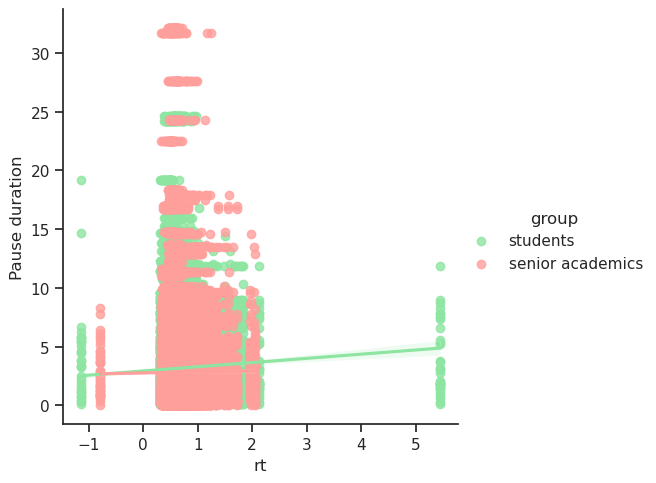

In [101]:
axs = sns.set_theme(style="ticks", palette="pastel");
axs = sns.lmplot(data=fullrt_for_cor, x='rt', y='Pause duration', hue='group', palette={'senior academics':'r', 'students':'g'});

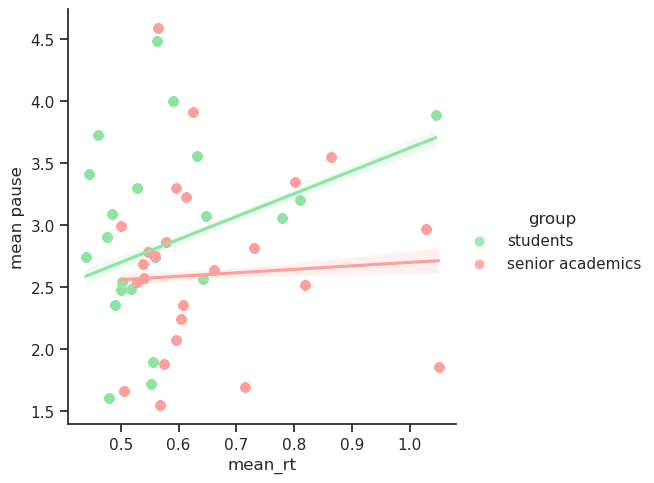

In [102]:
axs = sns.set_theme(style="ticks", palette="pastel");
axs = sns.lmplot(data=rt_for_cor, x='mean_rt', y='mean pause', hue='group', palette={'senior academics':'r', 'students':'g'});

In [103]:
fullrtcor = fullrt_for_cor.drop_duplicates()
x = fullrtcor['rt']
y = fullrtcor['Pause duration']
print(stats.pearsonr(x,y))    # Pearson's r

print(stats.spearmanr(x,y) )  # Spearman's rho

print(stats.kendalltau(x,y) ) # Kendall's tau

PearsonRResult(statistic=0.01126809401095126, pvalue=0.0023487189088430382)
SignificanceResult(statistic=0.03133976336539937, pvalue=2.6064567799228055e-17)
SignificanceResult(statistic=0.021168967784313444, pvalue=1.142816963015796e-17)


In [104]:
rtcor = rt_for_cor[['mean pause', 'mean_rt', 'ID', 'group']].drop_duplicates()
x = rtcor['mean_rt']
y = rtcor['mean pause']
print(stats.pearsonr(x,y))    # Pearson's r

print(stats.spearmanr(x,y) )  # Spearman's rho

print(stats.kendalltau(x,y) ) # Kendall's tau

PearsonRResult(statistic=0.10710010725138666, pvalue=0.4736611353323659)
SignificanceResult(statistic=0.1502081406105458, pvalue=0.31356107137254163)
SignificanceResult(statistic=0.1082331174838113, pvalue=0.2832966676073182)


In [105]:
rtcor.groupby('group').count()

,mean pause,mean_rt,ID
group,,,
senior academics,25,25,25
students,22,22,22


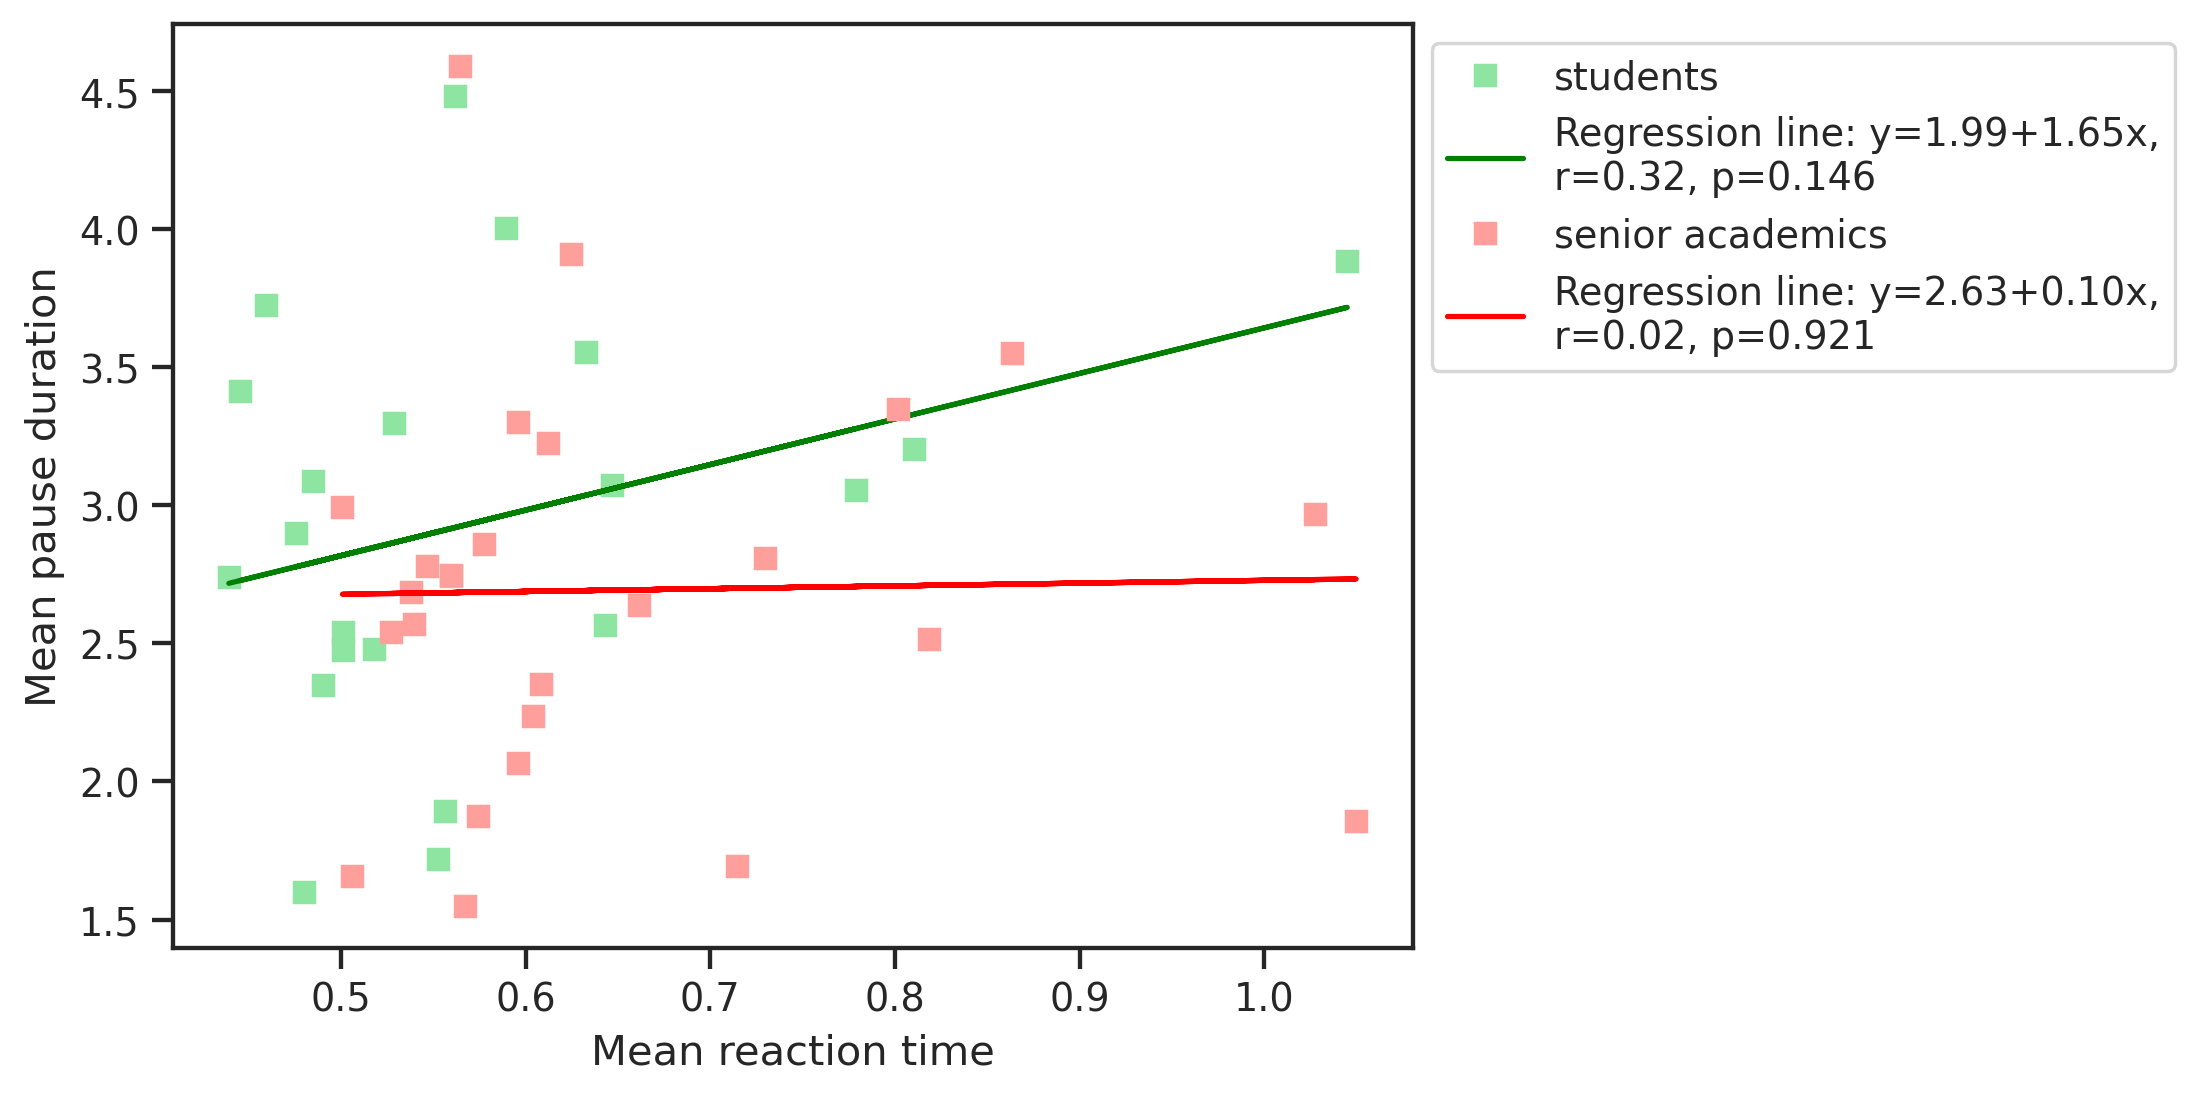

In [109]:
x1 = rtcor[rtcor['group']=='students']['mean_rt']
y1 = rtcor[rtcor['group']=='students']['mean pause']
x2 = rtcor[rtcor['group']!='students']['mean_rt']
y2 = rtcor[rtcor['group']!='students']['mean pause']

slope, intercept, r, p, stderr = stats.linregress(x1, y1)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x,\nr={r:.2f}, p={p:.3f}'
fig, ax = plt.subplots(dpi=250)
# ax.set_color_cycle(['green', 'red'])
ax.plot(x1, y1, linewidth=0, marker='s', label='students', color='g')
ax.plot(x1, intercept + slope * x1, label=line, color='green')

slope2, intercept2, r2, p2, stderr2 = stats.linregress(x2, y2)
line2 = f'Regression line: y={intercept2:.2f}+{slope2:.2f}x,\nr={r2:.2f}, p={p2:.3f}'
ax.plot(x2, y2, linewidth=0, marker='s', label='senior academics', color='r')
ax.plot(x2, intercept2 + slope2 * x2, label=line2, color='red')

ax.set_xlabel('Mean reaction time')
ax.set_ylabel('Mean pause duration')
ax.legend(facecolor='white',  bbox_to_anchor=(1, 1))
# plt.tight_layout()

# ax.legend(facecolor='white')
plt.show()
fig.savefig(f'figures/Mean reaction time ~ Mean pause duration.png', bbox_inches='tight')

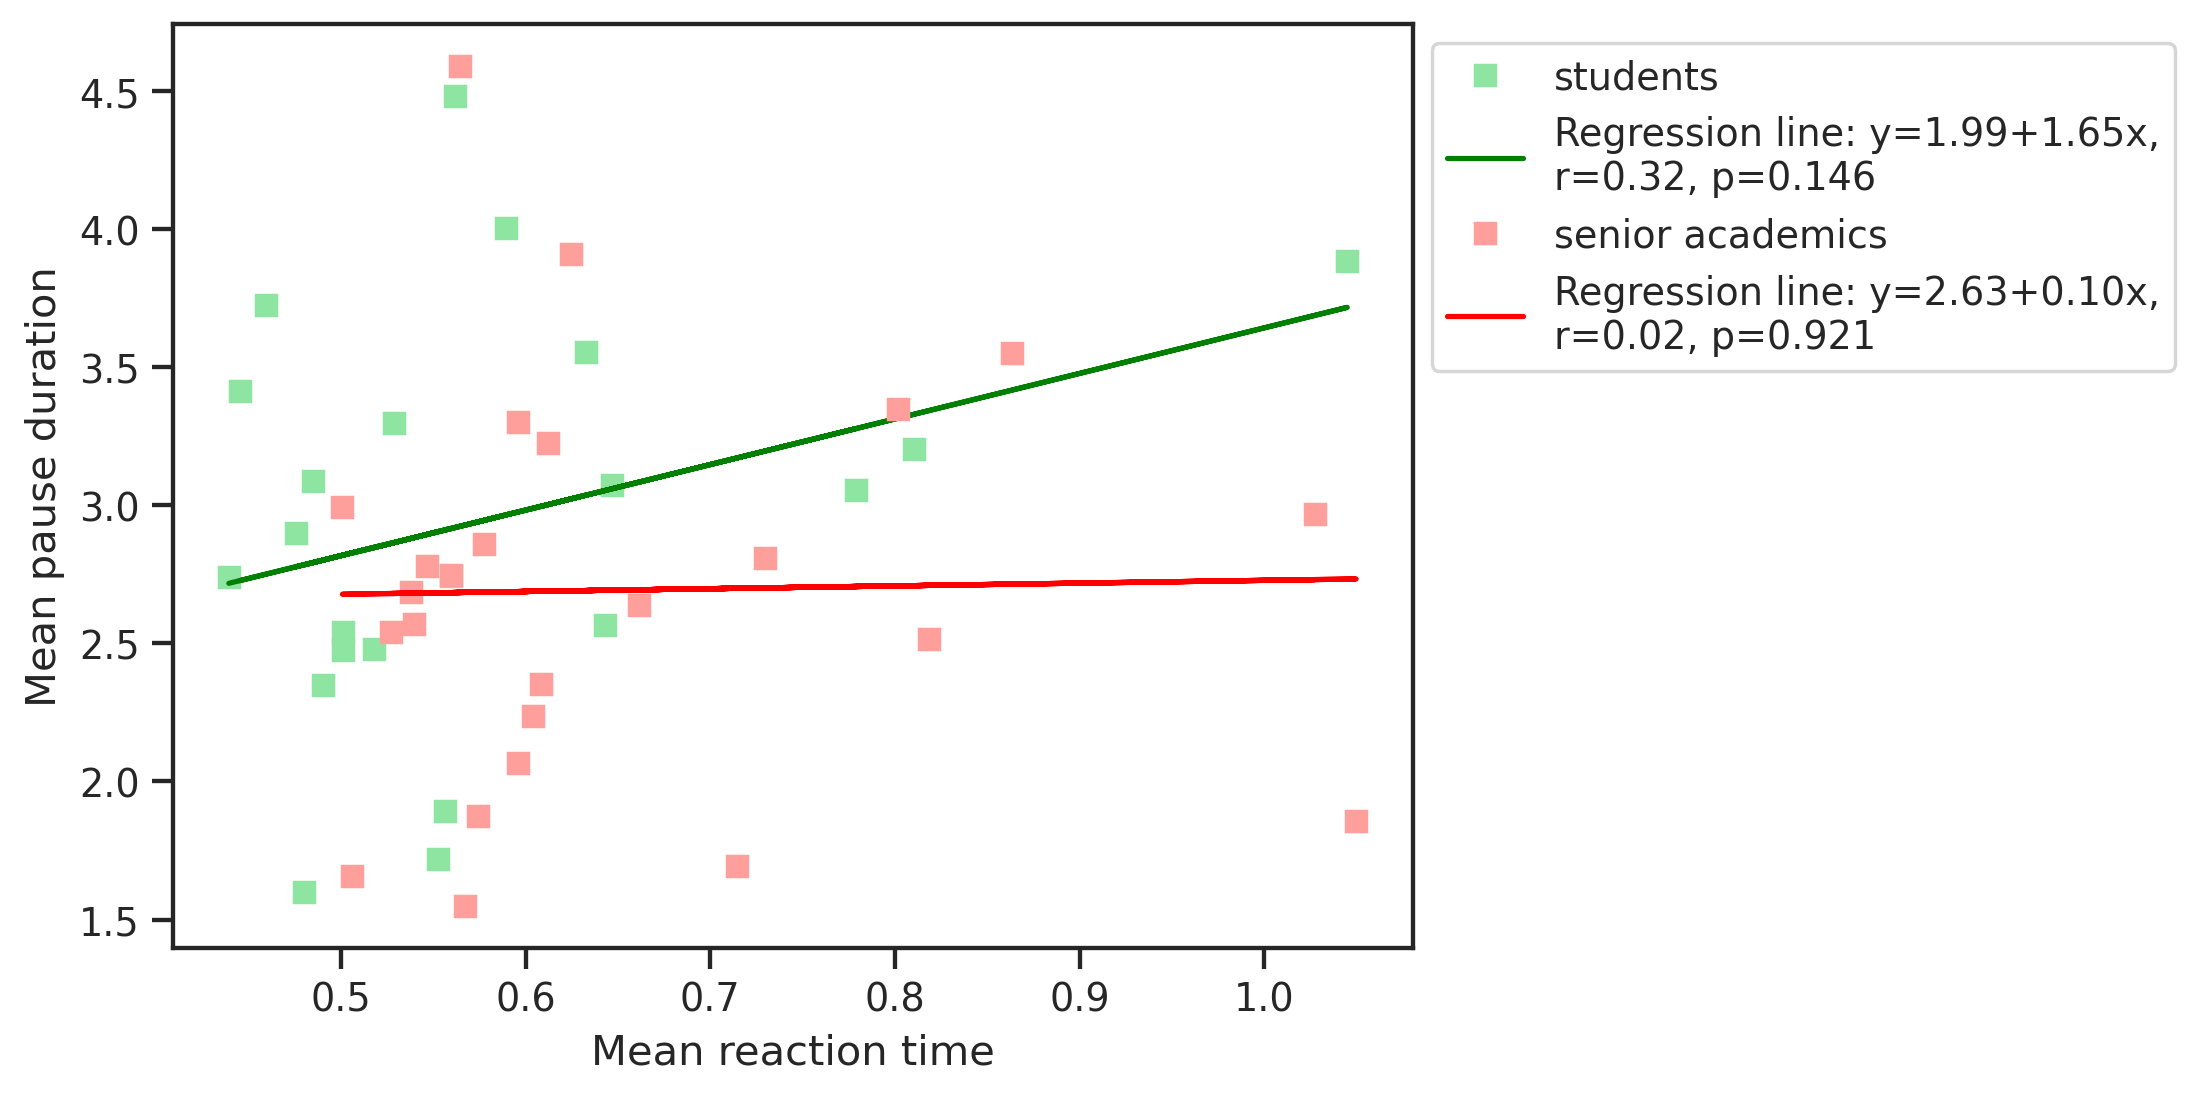

In [108]:
x1 = rtcor[rtcor['group']=='students']['mean_rt']
y1 = rtcor[rtcor['group']=='students']['mean pause']
x2 = rtcor[rtcor['group']!='students']['mean_rt']
y2 = rtcor[rtcor['group']!='students']['mean pause']

slope, intercept, r, p, stderr = stats.linregress(x1, y1)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x,\nr={r:.2f}, p={p:.3f}'
fig, ax = plt.subplots(dpi=250)
# ax.set_color_cycle(['green', 'red'])
ax.plot(x1, y1, linewidth=0, marker='s', label='students', color='g')
ax.plot(x1, intercept + slope * x1, label=line, color='green')

slope2, intercept2, r2, p2, stderr2 = stats.linregress(x2, y2)
line2 = f'Regression line: y={intercept2:.2f}+{slope2:.2f}x,\nr={r2:.2f}, p={p2:.3f}'
ax.plot(x2, y2, linewidth=0, marker='s', label='senior academics', color='r')
ax.plot(x2, intercept2 + slope2 * x2, label=line2, color='red')

ax.set_xlabel('Mean reaction time')
ax.set_ylabel('Mean pause duration')
ax.legend(facecolor='white',  bbox_to_anchor=(1, 1))
# plt.tight_layout()

# ax.legend(facecolor='white')
plt.show()

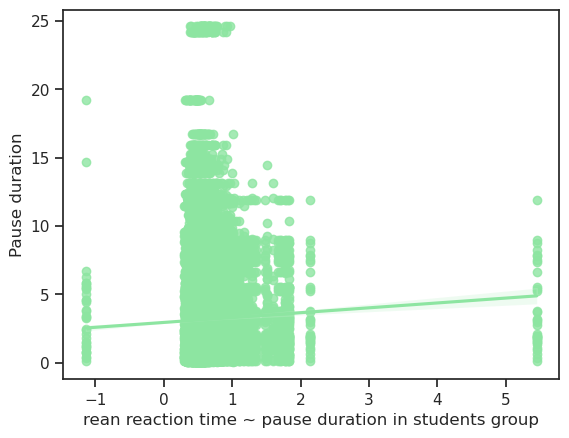

In [109]:
# fig, axs = plt.subplots(figsize=(8, 8), dpi=150)
# plt.figure(figsize=(10, 6))
    
# fig, axs = plt.subplots(figsize=(7, 7), dpi=120)

sns.regplot(data=fullrt_for_cor[fullrt_for_cor['group']=='students'], x='rt', y='Pause duration', color='g')
plt.xlabel('rean reaction time ~ pause duration in students group');

In [306]:
# sns.scatterplot(data=rt_for_cor, x='mean_rt', y='mean pause')

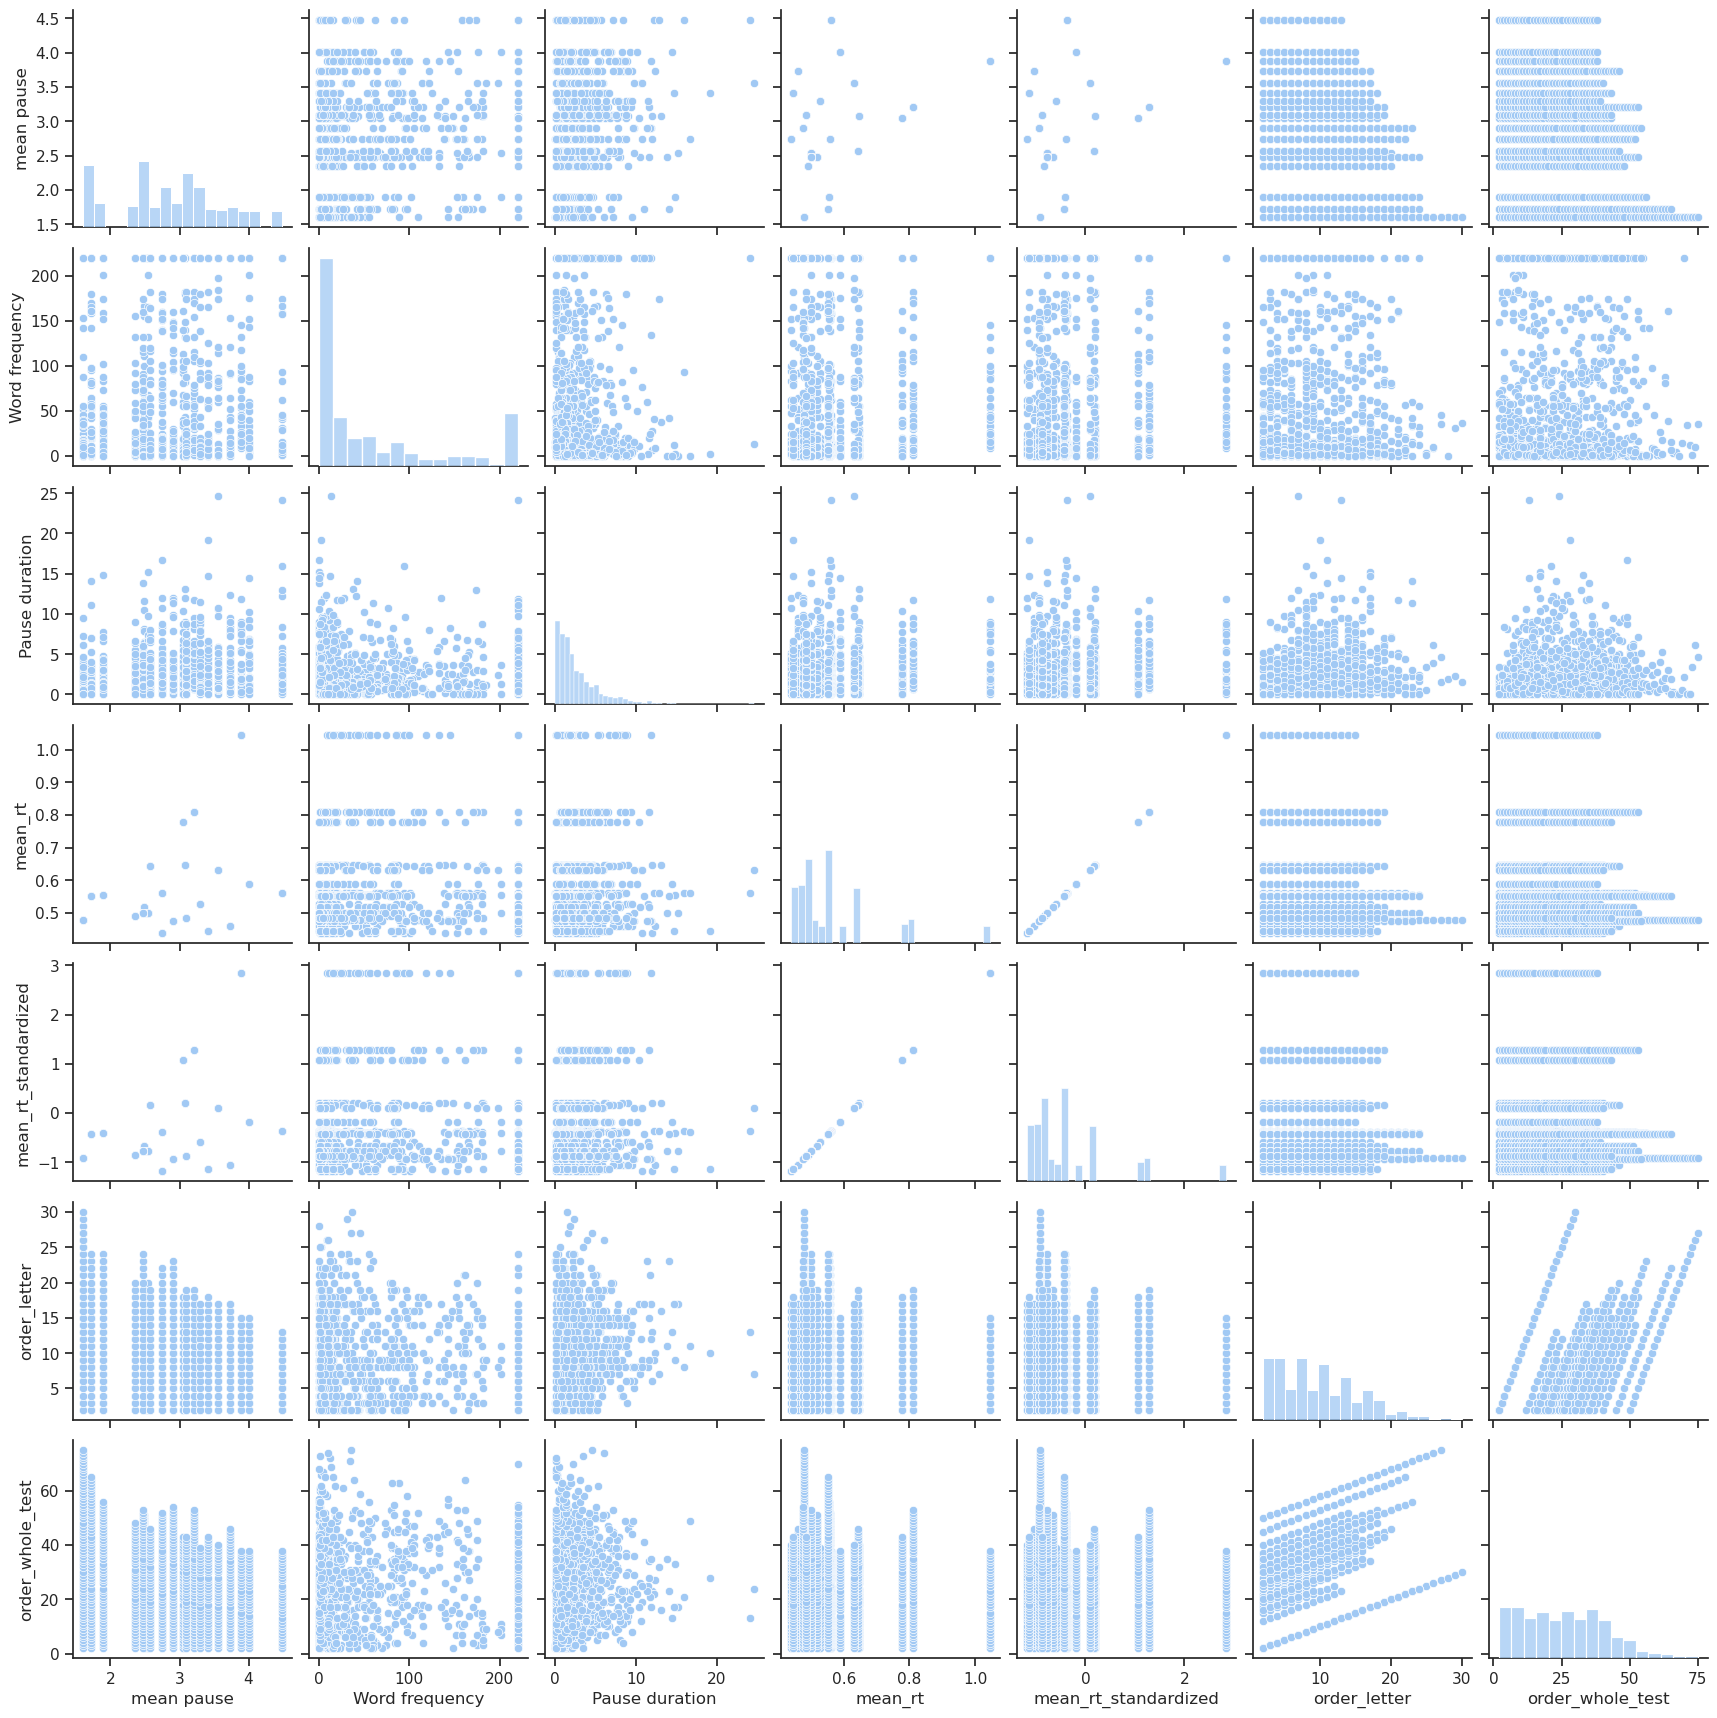

In [357]:
sns.pairplot(rt_for_cor[['mean pause', 
       'Word frequency', 'Pause duration', 'mean_rt', 
       'mean_rt_standardized', 'order_letter', 'order_whole_test']]);

In [304]:
# sns.lineplot(data=rt_for_cor, y='order_letter', x='Pause duration')

In [305]:
# sns.lineplot(data=rt_for_cor, x='mean_rt', y='Pause duration')
# sns.lineplot(data=rt_for_cor, x='mean_rt', y='mean pause')